## HMC Analysis

In [1]:
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')
sns.set_palette('bright')
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set(context="notebook")
sns.set_palette('bright')
#%matplotlib inline
#plt.style.use("/Users/saforem2/.config/matplotlib/stylelib/molokai.mplstyle")

In [3]:
def filter_dict(d, cond, key=None):
    if key is not None:
        val = d[key]
        if isinstance(val, dict):
            return {
                k: v for k, v in val.items() if cond
            }
        raise ValueError('If passing a key, d[key] should be a dict.')
    return {
        k: v for k, v in d.items() if cond
    }

In [4]:
def _look(p, s, conds=None):
    print(f'Looking in {p}...')
    matches = [x for x in Path(p).rglob(f'*{s}*')]
    if conds is not None:
        if isinstance(conds, (list, tuple)):
            for cond in conds:
                matches = [x for x in matches if cond(x)]
        else:
            matches = [x for x in matches if cond(x)]

    return matches

In [5]:
def _get_l2hmc_dirs(paths):
    def _look(p, s, conds=None):
        print(f'Looking in {p}...')
        matches = [x for x in Path(p).rglob(f'*{s}*')]
        if conds is not None:
            if isinstance(conds, (list, tuple)):
                for cond in conds:
                    matches = [x for x in matches if cond(x)]
            else:
                matches = [x for x in matches if cond(x)]
                
        return matches
    
    dirs = []
    conds = (
        lambda x: 'GaugeModel_logs' in (str(x)),
        lambda x: 'HMC_' not in str(x),
        lambda x: Path(x).is_dir(),
    )
    if isinstance(paths, (list, tuple)):
        for path in paths:
            dirs += _look(path, 'L16_b', conds)
            
    else:
        dirs = _look(paths, 'L16_b', conds)
        
            #print(f'Looking in {path}...')
            #dirs += [
            #    x for x in path.rglob('*L16_b*') 
            #    if 'GaugeModel_logs' in str(x)
            #    and 'HMC_' not in str(x)
            #    and x.is_dir()
            #]
            
    
    return dirs

def _get_hmc_dirs(paths):
    dirs = []
    for path in list(paths):
        path = Path(path)
        print(f'Looking in {path}...')
        dirs += [
            x for x in path.rglob('*hmc_logs*') 
            if 'hmc' in str(x).lower()
            and '_b128' in str(x)
            #if 'GaugeModel_logs' in str(x)
            #and 'HMC_' not in str(x)
            and x.is_dir()
        ]
    
    return dirs

In [6]:
import utils.file_io as io
from utils.attr_dict import AttrDict

def load_from_dir(d):
    darr = [x for x in d.iterdir() if x.is_dir()]
    
    for rd in darr:
        dqf = sorted(rd.glob('*dq.z*'))[0]
        qf = sorted(rd.glob('*charges.z*'))[0]
        pf = sorted(rd.rglob('*run_params.z*'))[0]
        
        dq = io.loadz(dqf)
        q = io.loadz(qf)
        rp = io.loadz(pf)
    pass
        

def load_charge_data(dirs, hmc=False):
    q = {}
    dq = {}
    for rd in dirs:
        print(f'Looking in dir: {rd}...')
        if 'inference_hmc' in str(rd):
            print(f'Skipping {str(rd)}...')
            continue
        #contents = os.listdir(d)
        
        #if hmc:
        #    run_dir = Path(os.path.join(d, 'inference_hmc'))
        #else:
        #    run_dir = Path(os.path.join(d, 'inference'))
            
        #if run_dir.is_dir():
        #run_dirs = []
        #for c in contents:
        #    run_dirs += [x for x in Path(os.path.join(d, c)).iterdir() if x.is_dir()]
            
        #run_dirs = [x for x in run_dir.iterdir() if x.is_dir()]
        #for rd in run_dirs:
        print(f'......looking in run_dir: {rd}...')
        dq_file = sorted(rd.rglob('dq.z'))
        q_file = sorted(rd.rglob('charges.z'))
        rp_file = sorted(rd.rglob('run_params.z'))
        num_runs = len(dq_file)
        if num_runs > 0:
            #for dqif, dqsf, qf, rpf in zip(dqi_file, dqs_file, q_file, rp_file):
            for dqf, qf, rpf in zip(dq_file, q_file, rp_file):
                params = io.loadz(rpf)

                if 'xeps' and 'veps' in params.keys():
                    xeps = np.array([i.numpy() for i in params['xeps']])
                    veps = np.array([i.numpy() for i in params['veps']])
                    eps = (np.mean(xeps) + np.mean(veps)) / 2.
                elif 'eps' in params.keys():
                    eps = params['eps']

                beta = params['beta']
                #eps = params['eps']
                num_steps = params['num_steps']
                print(f'........loading data for (beta, num_steps, eps): ({beta}, {num_steps}, {eps:.3g})...')
                def _update_dict(z, f):
                    try:
                        z[beta].update({
                            (num_steps, eps): io.loadz(f)
                        })
                    except KeyError:
                        z[beta] = {
                            (num_steps, eps): io.loadz(f)
                        }
                    return z
                q = _update_dict(q, qf)
                dq = _update_dict(dq, dqf)
                
    return AttrDict(q), AttrDict(dq)

tf.__version__: 2.5.0-dev20201121


## New heading

## Helper for computing statistics

In [7]:
from utils.data_utils import therm_arr 


def bootstrap_new(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps), replace=True)
    yb = xb.mean(axis=0)
    upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)
    avg = (upper + lower) / 2
    err = np.abs(upper - avg)
    return avg, err


def bootstrap1(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps))
    mb = xb.mean(axis=0)
    mb.sort()
    upper, lower = np.percentile(mb, [2.5, 97.5])
    return np.mean(mb), np.max([upper, lower])
    
    return mb, np.percentile(mb, [2.5, 97.5], axis=1)


def bootstrap(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps), replace=True)
    yb = xb.mean(axis=0)
    upper, lower = np.percentile(yb, [2.5, 97.5])
    
    return yb, max([upper - np.mean(yb), np.mean(yb) - lower])


def dq_stats(dq_dict, reps=1000, therm_frac=0.25):
    stats = {}
    avgs = {}
    errs = {}
    for key, val in dq_dict.items():
        print(120 * '-')
        print(f'key: {key}...')
        for k, v in val.items():
            print(f'.....key, val.shape: {k}, {v.shape}')
            data = therm_arr(v, therm_frac=therm_frac, ret_steps=False)
            print(f'.....key, therm_arr.shape: {k}, {data.shape}')
            avgs_ = []
            errs_ = []
            for chain in data.T:
                avg, err = bootstrap(chain, reps)
                avgs_.append(avg)
                errs_.append(err)
                
            print(f'.....key, avg: {k}, {np.mean(avgs_)} +/- {np.mean(errs_)}')
            try:
                avgs[key].update({'avgs': avgs_, 'errs': errs_})
            except KeyError:
                avgs[key] = {'avgs': avgs_, 'errs': errs_}
            try:
                stats[key].update({
                    k: {
                        'avg': np.mean(avgs_),
                        'avg_std': np.std(avgs_),
                        'err': np.mean(errs_),
                        'err_std': np.std(errs_),
                        'min': int(np.min(data)),
                        'max': int(np.max(data)),
                    }
                })
            except KeyError:
                stats[key] = {
                    k: {
                        'avg': np.mean(avgs_),
                        'std': np.std(avgs_),
                        'err': np.mean(errs_),
                        'err_std': np.std(errs_),
                        'min': int(np.min(data)),
                        'max': int(np.max(data)),
                    }
                }
                
    return stats, avgs, errs

In [8]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def integrated_autocorr5(x, size='cbrt'):
    r"""Estimate the integrated autocorrelation time, :math:`\tau_{int}` of a
    time series.

    This method uses the consistent non-overlapping batch means estimator [1]
    where the number of batches are chosen as functions of the overall run
    length.

    Parameters
    ----------
    x : ndarray, shape=(n_samples, n_dims)
        The time series, with time along axis 0.
    size : {'sqrt', 'cbrt'}
        The batch size. The default value is "sqroot", which uses the square
        root of the sample size. "cuberoot" will cause the function to use the
        cube root of the sample size. A numeric value may be provided if
        neither "sqrt" nor "cbrt" is satisfactory.

    References
    ----------
    .. [1] Flegal, J. M., Haran, M. and Jones, G. L. (2008) Markov chain Monte
       Carlo: Can we trust the third significant figure? Statistical Science,
       23, 250-260.

    Returns
    -------
    tau_int : ndarray, shape=(n_dims,)
      The estimated integrated autocorrelation time of each dimension in
      ``x``, considered independently.
    """
    if x.ndim == 1:
        x = x.reshape(-1, 1)

    if size == 'sqrt':
        batch_size = int(np.sqrt(x.shape[0]))
    elif size == 'cbrt':
        batch_size = int(x.shape[0]**0.5)
    elif np.isscalar(size):
        batch_size = size
    else:
        raise NotImplementedError('unrecoginized argument, size=%s' % size)

    bigvar = np.var(x, axis=0, ddof=1)
    # leave off the extra bit at the end that's not a clean multiple
    x = x[:batch_size*(len(x)//batch_size)]
    bigmean = np.mean(x, axis=0)

    sigma2_bm = np.zeros(x.shape[1])
    for j in range(x.shape[1]):
        # reshape into the batches, and then compute the batch-means
        bm = x[:, j].reshape(-1, batch_size).mean(axis=1)
        sigma2_bm[j] = (batch_size / (len(bm)-1)) * np.sum((bm-bigmean[j])**2)

    return sigma2_bm / bigvar

## Calculate $\tau_{\mathrm{int}}$ using ML

In [9]:
from scipy.optimize import minimize


def autocorr_ml(y, thin=1, c=5.0):
    # Compute the initial estimate of tau using the standard method
    init = autocorr_new(y, c=c)
    z = y[:, ::thin]
    N = z.shape[1]

    # Build the GP model
    tau = max(1.0, init / thin)
    kernel = terms.RealTerm(
        np.log(0.9 * np.var(z)), -np.log(tau), bounds=[(-5.0, 5.0), (-np.log(N), 0.0)]
    )
    kernel += terms.RealTerm(
        np.log(0.1 * np.var(z)),
        -np.log(0.5 * tau),
        bounds=[(-5.0, 5.0), (-np.log(N), 0.0)],
    )
    gp = celerite.GP(kernel, mean=np.mean(z))
    gp.compute(np.arange(z.shape[1]))

    # Define the objective
    def nll(p):
        # Update the GP model
        gp.set_parameter_vector(p)

        # Loop over the chains and compute likelihoods
        v, g = zip(*(gp.grad_log_likelihood(z0, quiet=True) for z0 in z))

        # Combine the datasets
        return -np.sum(v), -np.sum(g, axis=0)

    # Optimize the model
    p0 = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, jac=True, bounds=bounds)
    gp.set_parameter_vector(soln.x)

    # Compute the maximum likelihood tau
    a, c = kernel.coefficients[:2]
    tau = thin * 2 * np.sum(a / c) / np.sum(a)
    return tau


# Calculate the estimate for a set of different chain lengths
ml = np.empty(len(N))
ml[:] = np.nan
for j, n in enumerate(N[1:8]):
    i = j + 1
    thin = max(1, int(0.05 * new[i]))
    ml[i] = autocorr_ml(chain[:, :n], thin=thin)

NameError: name 'N' is not defined

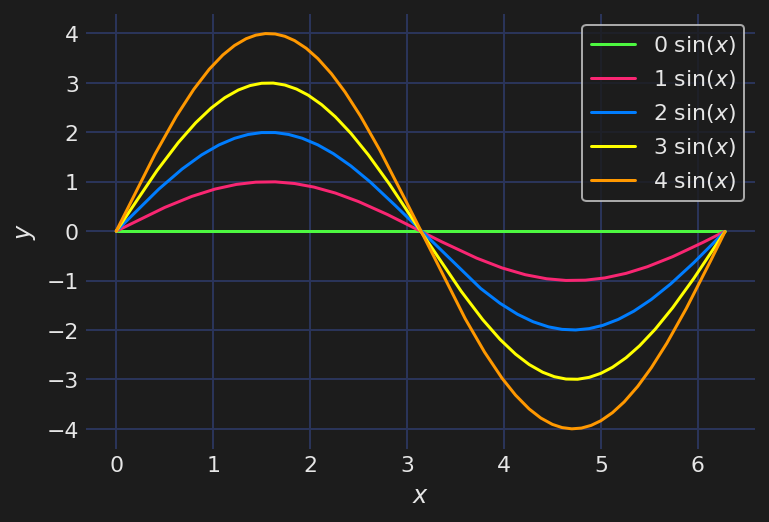

In [10]:
try:
    plt.style.use('molokai')
except:
    pass

fig, ax = plt.subplots()
x = np.arange(0, 2*np.pi, 0.02)
for i in range(5):
    _ = ax.plot(x, i * np.sin(x), label=f'{i} ' + r"$\sin(x)$")
    
_ = ax.legend(loc='best')
fig.set_facecolor('#1c1c1c')
_ = ax.set_xlabel(r"$x$")
_ = ax.set_ylabel(r"$y$")

#import tikzplotlib
#tikzplotlib.save("/Users/saforem2/Downloads/sin_tikz.tex")
# or
#tikzplotlib.save("mytikz.tex", flavor="context")a

Specify HMC dirs to look in for data

In [11]:
from config import LOGS_DIR
import glob
from pathlib import Path

hmc_dirs = []

# From `thetaGPU`:
#hmc_dir = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/')

# From local machine:
hmc_dir = os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc_2020_12_20/')
hmc_dir = Path(hmc_dir)

hmc_dirs = [x for x in hmc_dir.rglob('*HMC_L16*') if x.is_dir()]

# hmc_dir1 = os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/')
# hmc_dir1 = Path(hmc_dir1)

# hmc_dirs += [x for x in hmc_dir1.rglob('*HMC_L16*') if x.is_dir()]

In [12]:
len(hmc_dirs)

61

 Specify L2HMC dirs (from JLSE and thetaGPU) containing data

In [13]:
from pathlib import Path

# From thetaGPU:
base_dir_thetaGPU = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/training/')
if os.path.isdir(base_dir_thetaGPU):
    l2hmc_dirs = _get_l2hmc_dirs(base_dir_thetaGPU)
    
# From local machine:
base_dir_local = os.path.abspath('/Users/saforem2/thetaGPU/training/')
if os.path.isdir(base_dir_local):
    l2hmc_dirs = _get_l2hmc_dirs(base_dir_local)
    
    
l2hmc_dirs = sorted(l2hmc_dirs)
len(l2hmc_dirs)

# ====
# Older training runs, no longer needed with new (better) results as of (12/05/2020)
# base_dir1 = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/training_2020_11')
# l2hmc_dirs += _get_l2hmc_dirs(base_dir1)

Looking in /Users/saforem2/thetaGPU/training...


74

In [14]:
q_l2hmc, dqi_l2hmc = load_charge_data(l2hmc_dirs)
q_l2hmc.keys()

Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.194)...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.194)...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.196)...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.194)...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.192)...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.194)...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/LOADED/inference/L

........loading data for (beta, num_steps, eps): (6.0, 10, 0.184)...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_30/t16x16_b2048_lf10_bi5_bf6_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi5_bf6_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b2048__lf10_eps0184-2020-12-03-0031...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_11_30/t16x16_b2048_lf10_bi5_bf6_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi5_bf6_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b2048__lf10_eps0184-2020-12-03-0031...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_30/t16x16_b2048_lf10_bi5_bf6_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi5_bf6_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b2048__lf10_eps0184-2020-12-15-1757...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_11_30/t16x16_b2048_lf10_bi5_bf6_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi5_bf6_dp02_clip500_sepNets_NC

Looking in dir: /Users/saforem2/thetaGPU/training/2020_12_02/t16x16_b2048_lf10_bi6_bf7_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi6_bf7_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b1024__lf10_eps0208-2020-12-16-0858...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_12_02/t16x16_b2048_lf10_bi6_bf7_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi6_bf7_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b1024__lf10_eps0208-2020-12-16-0858...
........loading data for (beta, num_steps, eps): (7.0, 10, 0.181)...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_12_02/t16x16_b2048_lf10_bi6_bf7_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi6_bf7_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b2048__lf10_eps0208-2020-12-03-1720...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_12_02/t16x16_b2048_lf10_bi6_bf7_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi6_bf7_dp02_clip500_sepNets_NC

........loading data for (beta, num_steps, eps): (5.0, 10, 0.184)...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_12_04/t16x16_b2048_lf10_bi4_bf5_4ranks_REP/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b2048__lf10_eps0208-2020-12-05-1913...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_12_04/t16x16_b2048_lf10_bi4_bf5_4ranks_REP/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b2048__lf10_eps0208-2020-12-05-1913...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.197)...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_12_05/t16x16_b2048_lf10_bi5_bf6_4ranks_REP/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi5_bf6_dp02_clip500_sepNets_NCProj...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_12_05/t16x16_b2048_lf10_bi5_bf6_4ranks_REP/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi5_bf6_dp02_clip

........loading data for (beta, num_steps, eps): (5.0, 10, 0.209)...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_12_15/t16x16bi4bf5b2048epsDynamic/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b2048__lf10_eps005-2020-12-20-2159...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_12_15/t16x16bi4bf5b2048epsDynamic/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b2048__lf10_eps005-2020-12-20-2159...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_12_15/t16x16bi4bf5b2048epsDynamic/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b2048__lf10_eps005-2020-12-16-0310...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_12_15/t16x16bi4bf5b2048epsDynamic/l2hmc-qcd/logs/GaugeModel_logs/2020_12/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b2048__lf10

dict_keys([5.0, 6.0, 4.0, 7.0])

In [15]:
q_hmc, dqi_hmc = load_charge_data(hmc_dirs, hmc=True)
q_hmc.keys()

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta7_lf20_eps025-2020-12-20-0745...
......looking in run_dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta7_lf20_eps025-2020-12-20-0745...
........loading data for (beta, num_steps, eps): (7.0, 20, 0.25)...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf20_eps005-2020-12-20-0759...
......looking in run_dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf20_eps005-2020-12-20-0759...
........loading data for (beta, num_steps, eps): (6.0, 20, 0.05)...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf15_eps005-2020-12-20-0743...
......looking in run_dir: /Users/s

........loading data for (beta, num_steps, eps): (7.0, 15, 0.025)...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf20_eps025-2020-12-20-0749...
......looking in run_dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf20_eps025-2020-12-20-0749...
........loading data for (beta, num_steps, eps): (5.0, 20, 0.25)...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf10_eps005-2020-12-20-0728...
......looking in run_dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf10_eps005-2020-12-20-0728...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.05)...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_be

........loading data for (beta, num_steps, eps): (5.0, 15, 0.25)...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf10_eps025-2020-12-20-0728...
......looking in run_dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf10_eps025-2020-12-20-0728...
........loading data for (beta, num_steps, eps): (6.0, 10, 0.25)...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf25_eps025-2020-12-20-0748...
......looking in run_dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf25_eps025-2020-12-20-0748...
........loading data for (beta, num_steps, eps): (6.0, 25, 0.25)...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_bet

dict_keys([7.0, 6.0, 5.0])

In [16]:
q_hmc = {}
dqi_hmc = {}

beta_conds = [
    lambda beta: beta < 4.0,
    lambda beta: beta == 5.5,
]

for hdir in hmc_dirs:
    print(f'Looking in dir: {hdir}')
    dqif = sorted(hdir.rglob('dq.z'))
    qf = sorted(hdir.rglob('charges.z'))
    pf = sorted(hdir.rglob('run_params.z'))
    if len(dqif) > 0:
        for dqif_, qf_, pf_ in zip(dqif, qf, pf):
            #print(f'......looking in run_dir: {rd}...')
            
            params = io.loadz(pf[0])
            beta = params['beta']
            if 'xeps' and 'veps' in params.keys():
                xeps = np.array([i.numpy() for i in params['xeps']])
                veps = np.array([i.numpy() for i in params['veps']])
                eps = (np.mean(xeps) + np.mean(veps)) / 2.
            elif 'eps' in params.keys():
                eps = params['eps']
                
            #eps = params['eps']
            num_steps = params['num_steps']
            
            for cond in beta_conds:
                if cond(beta):
                    continue
                
            def _update_dict(d, f):
                try:
                    d[beta].update({
                        (num_steps, eps): io.loadz(f)
                    })
                except KeyError:
                    d[beta] = {
                        (num_steps, eps): io.loadz(f)
                    }

                return d

            q_hmc = _update_dict(q_hmc, qf_)
            dqi_hmc = _update_dict(dqi_hmc, dqif_)

q_hmc = AttrDict(q_hmc)
dqi_hmc = AttrDict(dqi_hmc)

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta7_lf20_eps025-2020-12-20-0745
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf20_eps005-2020-12-20-0759
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf15_eps005-2020-12-20-0743
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf20_eps02-2020-12-20-0742
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf15_eps015-2020-12-20-0817
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf20_eps02-2020-12-20-0745
Looking in dir: /Users/saforem2/thetaGPU/inferen

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf15_eps01-2020-12-20-0811
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf20_eps0025-2020-12-20-0803
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta6_lf25_eps015-2020-12-20-0808
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta7_lf10_eps015-2020-12-20-0753
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta5_lf10_eps0025-2020-12-20-0725
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b8_beta7_lf25_eps01-2020-12-20-0753
Looking in dir: /Users/saforem2/thetaGPU/infer

In [17]:
q_hmc.keys()

dict_keys([7.0, 6.0, 5.0])

In [18]:
from copy import deepcopy

q_hmc_copy = deepcopy(q_hmc)
q_l2hmc_copy = deepcopy(q_l2hmc)

In [19]:
q_hmc = {k: v for k, v in q_hmc.items() if k > 4.5 and k != 5.5}
q_hmc.keys()

dict_keys([7.0, 6.0, 5.0])

In [20]:
q_l2hmc = {k: v for k, v in q_l2hmc.items() if k > 4.5}
q_l2hmc.keys()

dict_keys([5.0, 6.0, 7.0])

In [21]:
q_l2hmc[5.0].keys()

dict_keys([(10, 0.19424471), (10, 0.19424184), (10, 0.1957567), (10, 0.19395266), (10, 0.191584), (10, 0.18413678), (10, 0.15467422), (10, 0.1970841), (10, 0.19755399), (10, 0.19559464), (10, 0.19497973), (10, 0.18409148), (10, 0.19657207), (10, 0.2090875655412674), (10, 0.20942947268486023), (10, 0.3142939805984497), (10, 0.15000000596046448), (10, 0.11966533958911896), (10, 0.2457892745733261)])

In [22]:
q_hmc[5.0].keys()

dict_keys([(15, 0.05000000447034836), (20, 0.20000000298023224), (25, 0.05000000074505806), (25, 0.25), (15, 0.15000000596046448), (15, 0.02500000223517418), (20, 0.10000000149011612), (10, 0.10000000149011612), (20, 0.15000002086162567), (20, 0.25), (10, 0.05000000074505806), (10, 0.20000000298023224), (25, 0.02500000037252903), (25, 0.15000000596046448), (20, 0.02500000037252903), (15, 0.25), (10, 0.15000000596046448), (20, 0.05000000074505806), (10, 0.25)])

In [23]:

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf


# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]


def calc_autocorr(y):
    N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 20)).astype(int)
    new = np.empty(len(N))
    for i, n in enumerate(N):
        new[i] = autocorr_new(y[:, :n])
        
    return N, new

In [24]:
from config import MARKERS, LOGS_DIR, FIGSIZE, TEX_FIGURES_DIR, PLOTS_DIR
from utils.data_utils import therm_arr
from utils.plotting_utils import set_size

H, W = FIGSIZE

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')
#plt.Axes.set_yticklabels()

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=(
   r"""
   \usepackage{amsmath}
   \usepackage[sups]{XCharter}
   \usepackage[scaled=1.04,varqu,varl]{inconsolata}
   \usepackage[type1]{cabin}
   \usepackage[charter,vvarbb,scaled=1.07]{newtxmath}
   \usepackage[cal=boondoxo]{mathalfa}
   """
))

In [27]:
# n_l2hmc = []
# tint_l2hmc = {}
# tint_l2hmc1 = {}
# tint_l2hmc2 = {}
# for key, val in q_l2hmc[5.0].items():
#     qarr, _ = therm_arr(val) # qarr.shape = [draws, chains]
#     qarr = qarr.T            # qarr.T.shape = [chains, draws]
#     chains, draws = qarr.shape
    
#     x1 = qarr[:chains//2 - 1]
#     x2 = qarr[chains//2:]
    
#     n1, tint1 = calc_autocorr(x1)
#     n2, tint2 = calc_autocorr(x2)
    
#     n, tint = calc_autocorr(qarr)
#     #n_l2hmc[key] = n
#     tint_l2hmc[key] = {'N': n, 'tint': tint}
#     tint_l2hmc1[key] = {'N': n1, 'tint': tint1}
#     tint_l2hmc2[key] = {'N': n2, 'tint': tint2}

# key = list(q_l2hmc[5.0].keys())[0]
# val = q_l2hmc[5.0][key]
# val.shape

# q = qarr[:, :100]

# n1, tint1 = calc_autocorr(qarr)
# n2, tint2 = calc_autocorr(q)

In [89]:
import time

def calc_tau_int(qdata, therm_frac=0.25, min_samples=-np.inf):
    tau_int = {key: {} for key, _ in qdata.items()}
    for key, val in qdata.items():
        print(f'* key: {key}')
        # tau_int[key] = {}
        for k, v in val.items():
            qarr, _ = therm_arr(v, therm_frac=therm_frac)  # qarr.shape = [draws, chains]
            qarr = qarr.T                            # qarr.T.shape = [chains, draws]

            chains, draws = qarr.shape
            chains, draws = qarr.shape
            
            if draws < min_samples:
                continue
                
            t0 = time.time()
            n, tint = calc_autocorr(qarr)
            t1 = time.time()
            print(f'  - traj_len: {k[0] * k[1]:.3g}, chains: {chains}, draws: {draws},'
                  f' n: {n[-1]}, tau_int: {tint[-1]:.3g}   (took: {t1 - t0:.3g}s)')
            # print(f'  - k, (chains, draws): {k}, ({chains}, {draws})')
            # print(f'      ~ n, tint: {n[-1]}, {tint[-1]:.3g}    (took: {t1 - t0:.3g}s)')
            
            #if np.isfinite(np.sum(np.isfinite(tint))) and np.isfinite(tint[-1]):
            if np.isfinite(tint[-1]):
                tau_int[key][k] = {
                    'N': n,
                    'tau_int': tint
                }
#                 tint_arr = []
#                 for idx, chain in enumerate(qarr[:3]):
#                     t0 = time.time()
#                     n_, tint_ = calc_autocorr(chain[:, None])
#                     tint_arr.append(tint_)
#                     t1 = time.time()
#                     print(f'      {idx} took ~ {t1 - t0:.4g}s')
#                     print(f'      {idx} n, tint: {n_}, {tint_}')
                
                
#                 print(f'  - tint_arr.mean: {np.mean(tint_arr)} +/- {np.std(tint_arr)}')



            # x1 = qarr[:chains//2-1].flatten()
            # x2 = qarr[chains//2:].flatten()

            # n0, tint0 = calc_autocorr(qarr)
            # n1, tint1 = calc_autocorr(x1[:, None])
            # n2, tint2 = calc_autocorr(x2[:, None])

            # n, tint = calc_autocorr(qarr)
            # tau_int[key][k] = {
            #     'N': n,
            #     'tau_int': tint,
            # }

    return tau_int

In [90]:
tint_l2hmc = calc_tau_int(q_l2hmc, therm_frac=0.2, min_samples=1e3)

* key: 5.0
  - traj_len: 1.94, chains: 2048, draws: 4000, n: 3999, tau_int: 32.1   (took: 5.67s)
  - traj_len: 1.94, chains: 512, draws: 8000, n: 8000, tau_int: 36.3   (took: 2.06s)
  - traj_len: 1.96, chains: 512, draws: 8000, n: 8000, tau_int: 39.6   (took: 2.06s)
  - traj_len: 1.94, chains: 512, draws: 20000, n: 19999, tau_int: 39.7   (took: 5.1s)
  - traj_len: 1.92, chains: 512, draws: 100000, n: 100000, tau_int: 42.2   (took: 24s)


/Users/saforem2/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


  - traj_len: 1.84, chains: 2048, draws: 4000, n: 3999, tau_int: 63   (took: 5.62s)
  - traj_len: 1.55, chains: 8, draws: 100000, n: 100000, tau_int: nan   (took: 0.374s)
  - traj_len: 1.97, chains: 2048, draws: 4000, n: 3999, tau_int: 41.8   (took: 5.78s)
  - traj_len: 1.98, chains: 2048, draws: 4000, n: 3999, tau_int: 41.4   (took: 5.85s)
  - traj_len: 1.96, chains: 512, draws: 8000, n: 8000, tau_int: 50.6   (took: 2.2s)
  - traj_len: 1.95, chains: 512, draws: 20000, n: 19999, tau_int: 51.6   (took: 5.29s)
  - traj_len: 1.84, chains: 8, draws: 100000, n: 100000, tau_int: 194   (took: 0.369s)
  - traj_len: 1.97, chains: 2048, draws: 4000, n: 3999, tau_int: 41.6   (took: 5.89s)
  - traj_len: 2.09, chains: 2048, draws: 20000, n: 19999, tau_int: 43.3   (took: 21.4s)
  - traj_len: 2.09, chains: 2048, draws: 4000, n: 3999, tau_int: 37.8   (took: 5.72s)
  - traj_len: 3.14, chains: 2048, draws: 4000, n: 3999, tau_int: 37.1   (took: 5.7s)
  - traj_len: 1.5, chains: 2048, draws: 4000, n: 3999,

In [91]:
tint_hmc = calc_tau_int(q_hmc, therm_frac=0.2, min_samples=1e3)

* key: 7.0


/Users/saforem2/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


  - traj_len: 5, chains: 8, draws: 100000, n: 100000, tau_int: nan   (took: 0.352s)
  - traj_len: 0.625, chains: 8, draws: 100000, n: 100000, tau_int: 8.94e+03   (took: 0.362s)
  - traj_len: 0.5, chains: 8, draws: 100000, n: 100000, tau_int: 9.27e+03   (took: 0.373s)
  - traj_len: 3.75, chains: 8, draws: 100000, n: 100000, tau_int: nan   (took: 0.344s)
  - traj_len: 2, chains: 8, draws: 100000, n: 100000, tau_int: 5.94e+03   (took: 0.339s)
  - traj_len: 2, chains: 8, draws: 100000, n: 100000, tau_int: 1e+04   (took: 0.323s)
  - traj_len: 0.375, chains: 8, draws: 100000, n: 100000, tau_int: 9.11e+03   (took: 0.32s)
  - traj_len: 0.25, chains: 8, draws: 100000, n: 100000, tau_int: 1.13e+04   (took: 0.332s)
  - traj_len: 0.75, chains: 8, draws: 100000, n: 100000, tau_int: 8.37e+03   (took: 0.371s)
  - traj_len: 3.75, chains: 8, draws: 100000, n: 100000, tau_int: 4.86e+03   (took: 0.325s)
  - traj_len: 3, chains: 8, draws: 100000, n: 100000, tau_int: 4.39e+03   (took: 0.343s)
  - traj_len:

In [92]:
from matplotlib import cm 

beta_str = {
    5.0: r"$5$",
    6.0: r"$6$",
    7.0: r"$7$",
}

tl_hmc = []
tl_l2hmc = []
traj_lengths_hmc = {}
traj_lengths_l2hmc = {}
for key, val in tint_hmc.items():
    traj_lengths_hmc[key] = {
        k: k[0] * k[1] for k in val.keys()
    }
    tl_hmc = [k[0] * k[1] for k in val.keys()]
    
for key, val in tint_l2hmc.items():
    traj_lengths_l2hmc[key] = {
        k: k[0] * k[1] for k in val.keys()
    }
    tl_l2hmc = [k[0] * k[1] for k in val.keys()]
    
io.print_dict(traj_lengths_hmc)
io.print_dict(traj_lengths_l2hmc)
tl_hmc = np.unique(tl_hmc)
tl_l2hmc = np.unique(tl_l2hmc)

7.0:
---
  (25, 0.02500000037252903): 0.6250000093132257
  (10, 0.05000000074505806): 0.5000000074505806
  (20, 0.10000000149011612): 2.0000000298023224
  (10, 0.20000000298023224): 2.0000000298023224
  (15, 0.02500000223517418): 0.3750000335276127
  (10, 0.02500000037252903): 0.2500000037252903
  (15, 0.05000000447034836): 0.7500000670552254
  (25, 0.15000000596046448): 3.750000149011612
  (20, 0.15000002086162567): 3.0000004172325134
  (25, 0.20000000298023224): 5.000000074505806
  (25, 0.05000000074505806): 1.2500000186264515
  (15, 0.15000000596046448): 2.250000089406967
  (20, 0.05000000074505806): 1.0000000149011612
  (20, 0.20000000298023224): 4.000000059604645
  (20, 0.02500000037252903): 0.5000000074505806
  (10, 0.15000000596046448): 1.5000000596046448
  (25, 0.10000000149011612): 2.500000037252903
6.0:
---
  (20, 0.05000000074505806): 1.0000000149011612
  (20, 0.20000000298023224): 4.000000059604645
  (15, 0.15000000596046448): 2.250000089406967
  (15, 0.05000000447034836): 

In [129]:
hdata = {}
for key, val in tint_hmc.items():
    vsort = dict(sorted(val.items()))
    hdata[key] = {k[0] * k[1]: v for k, v in vsort.items()}
    
ldata = {}
for key, val in tint_l2hmc.items():
    vsort = dict(sorted(val.items()))
    ldata[key] = {k[0] * k[1]: v for k, v in vsort.items()}
    
#hdata = dict(sorted(hdata, key=lambda d: d[0]))
hdata = dict(sorted(hdata.items()))
ldata = dict(sorted(ldata.items()))
#io.print_dict(hdata)
io.print_dict(ldata)

5.0:
---
1.1966533958911896:
------------------
  N: [  100   132   174   230   305   403   532   704   930  1230  1625  2148
  2839  3753  4960  6555  8663 11450 15132 19999]
  tau_int: [  9.94609785  13.49058425  18.110947    23.94613556  30.71461487
  40.55742244  51.56380755  65.2184468   81.40188535 100.32471688
 123.93942002 147.95208193 174.86421737 200.59908565 227.38044703
 253.583433   280.36159777 300.74880952 318.62907272 340.82476677]
1.5000000596046448:
------------------
  N: [ 100  121  147  179  217  263  320  389  472  573  696  846 1027 1247
 1515 1839 2234 2712 3294 3999]
  tau_int: [  8.9218439   10.98088722  13.75545863  17.35219493  21.30267514
  26.37726679  32.55250686  40.15927902  48.74013985  59.96974125
  72.34710891  86.90613171 104.70146838 125.51058999 149.24131421
 174.8796169  203.09717729 237.8747529  277.17408112 318.75814037]
1.840914785861969:
-----------------
  N: [   100    143    206    297    428    615    885   1274   1832   2636
   3792   54

In [130]:
ldata.keys()

dict_keys([5.0, 6.0, 7.0])

In [131]:
for key, val in ldata.items():
    for k, v in val.items():
        m = np.max(v['tau_int'])
        if m > 10:
            print(f"max(ldata[{key}][{k:.2g}]['tau_int']) = {m}")

max(ldata[5.0][1.2]['tau_int']) = 340.82476677114084
max(ldata[5.0][1.5]['tau_int']) = 318.7581403717626
max(ldata[5.0][1.8]['tau_int']) = 228.65970223272367
max(ldata[5.0][1.9]['tau_int']) = 42.181332534332476
max(ldata[5.0][1.9]['tau_int']) = 39.70575588611293
max(ldata[5.0][1.9]['tau_int']) = 36.299296327378876
max(ldata[5.0][1.9]['tau_int']) = 32.130146791319476
max(ldata[5.0][1.9]['tau_int']) = 51.646028515599816
max(ldata[5.0][2]['tau_int']) = 50.60482252113623
max(ldata[5.0][2]['tau_int']) = 39.59137972499656
max(ldata[5.0][2]['tau_int']) = 41.629097984038204
max(ldata[5.0][2]['tau_int']) = 41.811001775932404
max(ldata[5.0][2]['tau_int']) = 41.37736337717521
max(ldata[5.0][2.1]['tau_int']) = 43.291634443621724
max(ldata[5.0][2.1]['tau_int']) = 37.83131001613105
max(ldata[5.0][2.5]['tau_int']) = 43.166266473589616
max(ldata[5.0][3.1]['tau_int']) = 37.14669133395656
max(ldata[6.0][0.7]['tau_int']) = 420.60962282490163
max(ldata[6.0][1.8]['tau_int']) = 74.02723994271743
max(ldata[6

In [132]:
outdir = os.path.abspath('/Users/saforem2/l2hmc-qcd/plots/tau_int_plots/data')
io.check_else_make_dir(outdir)

houtfile = os.path.join(outdir, 'qdata.z')
io.savez(hdata, houtfile, name='qdata')

loutfile = os.path.join(outdir, 'ldata.z')
io.savez(ldata, loutfile, name='ldata')



Saving qdata to /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/data/qdata.z.
Saving ldata to /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/data/ldata.z.


In [133]:
houtfile = os.path.join(outdir, 'q_hmc.z')
io.savez(q_hmc, houtfile, name='q_hmc')

loutfile = os.path.join(outdir, 'q_l2hmc.z')
io.savez(q_l2hmc, loutfile, name='q_l2hmc')

Saving q_hmc to /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/data/q_hmc.z.
Saving q_l2hmc to /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/data/q_l2hmc.z.


In [134]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

legdict = {
    0.25: r"$0.25$",
    1.5: r"$1.5$",
    1.54: r"$1.54$",
    1.8: r"$1.8$",
    1.81: r"$1.81$",
    1.82: r"$1.82$",
    2.09: r"$2.09",
    1.84: r"$1.84$",
    3: r"$3.00$",
    4: r"$4.00$",
    5: r"$5.00$",
    6.25: r"$6.25$",
}

def plot_autocorrs(beta, l2hmc_data, hmc_data, out_dir=None, ax=None, labels=True, cmap='Blues'):
    if ax is None:
        _, ax = plt.subplots()
        
    num_items = len(list(hmc_data.keys()))
    #cmap = plt.get_cmap('Blues', num_items + 10)
    cmap = plt.get_cmap(cmap, num_items + 10)
    good_idxs = [0, num_items - 1, (num_items - 1) // 2]
    for idx, (key, val) in enumerate(hmc_data.items()):
        #if not np.isfinite(val['tau_int'][-1]) or max(val['tau_int']) > 500:
        if not np.sum(np.isfinite(val['tau_int'])) or max(val['N']) < 1e3 or np.sum(val['tau_int']) < 100:
            continue
            
        #if (idx == 0 or idx == num_items - 1 or idx == (num_items - 1) // 2):
        #if idx in good_idxs:
        if beta == 7. and idx == 0:  # and idx in good_idxs:
            label = f'HMC, ' r"$N_{\mathrm{LF}} \cdot \varepsilon$ = " 
            try:
                label += legdict[np.round(key, 2)] #  +f'{key:.2g}'
            except KeyError:
                label += f'${{{key:.2g}}}$'
        else:
            label = None
            
        _ = ax.loglog(val['N'], val['tau_int'], marker='.', ls='', lw=0.8, alpha=0.8, color=cmap(idx+10), label=label) #, label=f'HMC: {str(key)}')
        
    for idx, (key, val) in enumerate(l2hmc_data.items()):
        #if max(val['N']) < 1e3 or not np.isfinite(val['tau_int'][-1]) or max(val['tau_int']) > 500:
        #if not np.sum(np.isfinite(val['tau_int'])):
        if not np.sum(np.isfinite(val['tau_int'])) or max(val['N']) < 1e4 or np.sum(val['tau_int']) < 100:
            continue
            
        #@if idx in good_idxs:
        if beta == 7. and idx == 0:
            label = f'L2HMC, ' r"$N_{\mathrm{LF}} \cdot \varepsilon \simeq $" 
            try:
                label += legdict[np.round(key, 1)]
            except KeyError:
                label += f'${{{key:.2g}}}$'
                
        else:
            label = None
            
        _ = ax.loglog(val['N'], val['tau_int'], marker='.', ls='', fillstyle='none', color='k', lw=0.8, label=label) # , label=f'L2HMC: {str(key)}')

    _ = ax.set_title(r"$\beta = $" + beta_str[beta])
    
    if beta == 7.:
        _ = ax.legend(loc='best', bbox_to_anchor=(1.0, 1.03), markerscale=1.5)
        #_ = ax.legend(loc='best', markerscale=1.5)
        
    #if beta == 7.:
    #    _ = ax.legend(loc='best', bbox_to_anchor=(1.0, 1.04), markerscale=1.5)
        
    if out_dir is not None:
        outfile = os.path.join(out_dir, f'tau_int_chains_beta{beta}'.replace('.', '') + '.png')
        print(f'Saving figure to: {outfile}')
        plt.savefig(outfile, dpi=400, bbox_inches='tight')

In [135]:
import utils.file_io as io

betas = list(tint_l2hmc.keys())
#io.print_dict(tint_l2hmc[7.0])

#tint_l2hmc[7.0].keys()
tint_l2hmc[7.0] = {k: v for k, v in tint_l2hmc[7.0].items() if k[1] > 0.16}
#tint_l2hmc[7.0].keys()

In [136]:
#ldata[7.0] = {k: v for k, v in ldata[7.0].items() if np.isfinite(np.sum(v['tau_int']))}

#ldata[6.0] = {k: v for k, v in ldata[6.0].items() if k > 1.501}

In [137]:
ldata.keys()

dict_keys([5.0, 6.0, 7.0])

In [138]:
io.print_dict(ldata[7.0])

1.8032105267047882:
------------------
  N: [ 100  121  147  179  217  263  320  389  472  573  696  846 1027 1247
 1515 1839 2234 2712 3294 3999]
  tau_int: [ 9.58212075 11.37080253 13.32914018 15.79333903 18.01311114 20.89622327
 24.07524067 27.37469688 31.28016971 34.6715284  38.23782124 41.68823527
 44.92395098 47.91036769 51.33822422 54.54130307 57.95768699 60.25730853
 63.39948375 65.26937095]
1.8118171393871307:
------------------
  N: [  100   132   174   230   305   403   532   704   930  1230  1625  2148
  2839  3753  4960  6555  8663 11450 15132 19999]
  tau_int: [        nan 12.13609513 15.41675411 19.10894413 23.22928135 27.8734651
 32.47704709 38.04897859 42.80683909 48.87875811 53.50435371 58.06258246
 61.99045565 65.26616373 68.8977916  71.50689513 72.92551129 75.12760165
 76.27403539 76.9925569 ]
1.8128743767738342:
------------------
  N: [ 100  121  147  179  217  263  320  389  472  573  696  846 1027 1247
 1515 1839 2234 2712 3294 3999]
  tau_int: [ 9.44531445 11.0

In [139]:
io.print_dict(ldata[6.0])

0.7011525332927704:
------------------
  N: [ 100  121  147  179  217  263  320  389  472  573  696  846 1027 1247
 1515 1839 2234 2712 3294 3999]
  tau_int: [  2.78702099   3.59669594   5.48735522   7.5742786   10.53328972
  15.2960377   21.54999771  29.51055183  38.58893643  50.97953849
  64.50379743  81.03898429 101.34523744 126.37005047 155.97908701
 191.9203134  236.05509719 287.96617853 349.11741997 420.60962282]
1.6606886684894562:
------------------
  N: [   100    143    206    297    428    615    885   1274   1832   2636
   3792   5455   7847  11288  16237  23357  33598  48329  69519 100000]
  tau_int: [          nan           nan           nan           nan   63.53729434
   69.48529196   97.90739444  123.42902491  210.39841849  295.38351277
  384.81027923  573.57272647  792.57346546  950.03587385 1071.45815309
 1501.12665481 1901.511165   1802.61011808 2423.76197109 2945.16186117]
1.7748458683490753:
------------------
  N: [   100    143    206    297    428    615    885 

In [140]:
# ldata_ = {k: {} for k, _ in ldata.items()}
# for key, val in ldata.items():
#     for k, v in val.items():
#         if np.sum(np.isfinite(v['tau_int'])):
#             ldata_[key][k] = {
#                 'N': v['N'],
#                 'tau_int': v['tau_int']
#             }
            
# hdata_ = {k: {} for k, _ in hmc_data.items()}
# for key, val in hdata.items():
#     for k, v in val.items():
#         if np.sum(np.isfinite(v['tau_int'])):
#             hdata_[key][k] = {
#                 'N': v['N'],
#                 'tau_int': v['tau_int'],
#             }

In [142]:
# for beta in betas:
#     ldata = l2hmc_data[beta]
#     for k, v in ldata.items():
#         m = np.max(v['tau_int'])
#         if m > 10:
#             print(f"l2hmc_data[{beta}][{k}]['tau_int'] = {m}")

In [143]:
l2hmc_data.keys()

dict_keys([1.595885008573532, 1.8032105267047882, 1.8118171393871307, 1.8128743767738342, 1.8153780698776245, 1.8196427822113037, 1.8471913039684296, 1.8778300285339355])

In [144]:
l2hmc_data.keys()

dict_keys([1.595885008573532, 1.8032105267047882, 1.8118171393871307, 1.8128743767738342, 1.8153780698776245, 1.8196427822113037, 1.8471913039684296, 1.8778300285339355])

In [152]:
ldata_ = {beta: {} for beta in betas}
for key, val in ldata.items():
    for k, v in val.items():
        tint = v['tau_int']
        mtint = np.max(tint)
        if mtint > 200:
            continue
            
        #if 50 < mtint < np.inf:
        #if mtint < 500:
        #if np.isfinite(mtint):
        print(f'{key}, {k:.3g}: {mtint}')
        ldata_[key][k] = {
            'N': v['N'],
            'tau_int': v['tau_int'],
        }
#         if tint[-1] > 100:
#             ldata[key][k] = {
#                 'N': v['N'],
#                 'tau_int': v['tau_int'],
#             }
            
#         else:
#             print(f'skipping ({key}, {k:.3g}): {tint[-1]:.3g}')
            
    

5.0, 1.84: nan
5.0, 1.92: 42.181332534332476
5.0, 1.94: 39.70575588611293
5.0, 1.94: 36.299296327378876
5.0, 1.94: 32.130146791319476
5.0, 1.95: 51.646028515599816
5.0, 1.96: 50.60482252113623
5.0, 1.96: 39.59137972499656
5.0, 1.97: 41.629097984038204
5.0, 1.97: 41.811001775932404
5.0, 1.98: 41.37736337717521
5.0, 2.09: 43.291634443621724
5.0, 2.09: 37.83131001613105
5.0, 2.46: 43.166266473589616
5.0, 3.14: 37.14669133395656
6.0, 1.66: nan
6.0, 1.77: nan
6.0, 1.78: 74.02723994271743
6.0, 1.8: nan
6.0, 1.82: 50.728769390973696
6.0, 1.83: nan
6.0, 1.84: 86.67982674676271
6.0, 1.84: 45.74545650879745
6.0, 1.88: nan
6.0, 1.88: 59.98499058802275
7.0, 1.8: 65.26937095153635
7.0, 1.81: nan
7.0, 1.81: 60.95090400812877
7.0, 1.82: 54.35157822308989
7.0, 1.82: 90.32190044721615
7.0, 1.85: nan
7.0, 1.88: nan


In [153]:
io.print_dict(ldata[7.0])

1.8032105267047882:
------------------
  N: [ 100  121  147  179  217  263  320  389  472  573  696  846 1027 1247
 1515 1839 2234 2712 3294 3999]
  tau_int: [ 9.58212075 11.37080253 13.32914018 15.79333903 18.01311114 20.89622327
 24.07524067 27.37469688 31.28016971 34.6715284  38.23782124 41.68823527
 44.92395098 47.91036769 51.33822422 54.54130307 57.95768699 60.25730853
 63.39948375 65.26937095]
1.8118171393871307:
------------------
  N: [  100   132   174   230   305   403   532   704   930  1230  1625  2148
  2839  3753  4960  6555  8663 11450 15132 19999]
  tau_int: [        nan 12.13609513 15.41675411 19.10894413 23.22928135 27.8734651
 32.47704709 38.04897859 42.80683909 48.87875811 53.50435371 58.06258246
 61.99045565 65.26616373 68.8977916  71.50689513 72.92551129 75.12760165
 76.27403539 76.9925569 ]
1.8128743767738342:
------------------
  N: [ 100  121  147  179  217  263  320  389  472  573  696  846 1027 1247
 1515 1839 2234 2712 3294 3999]
  tau_int: [ 9.44531445 11.0

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/2020-12-20/tau_int_scatter.png


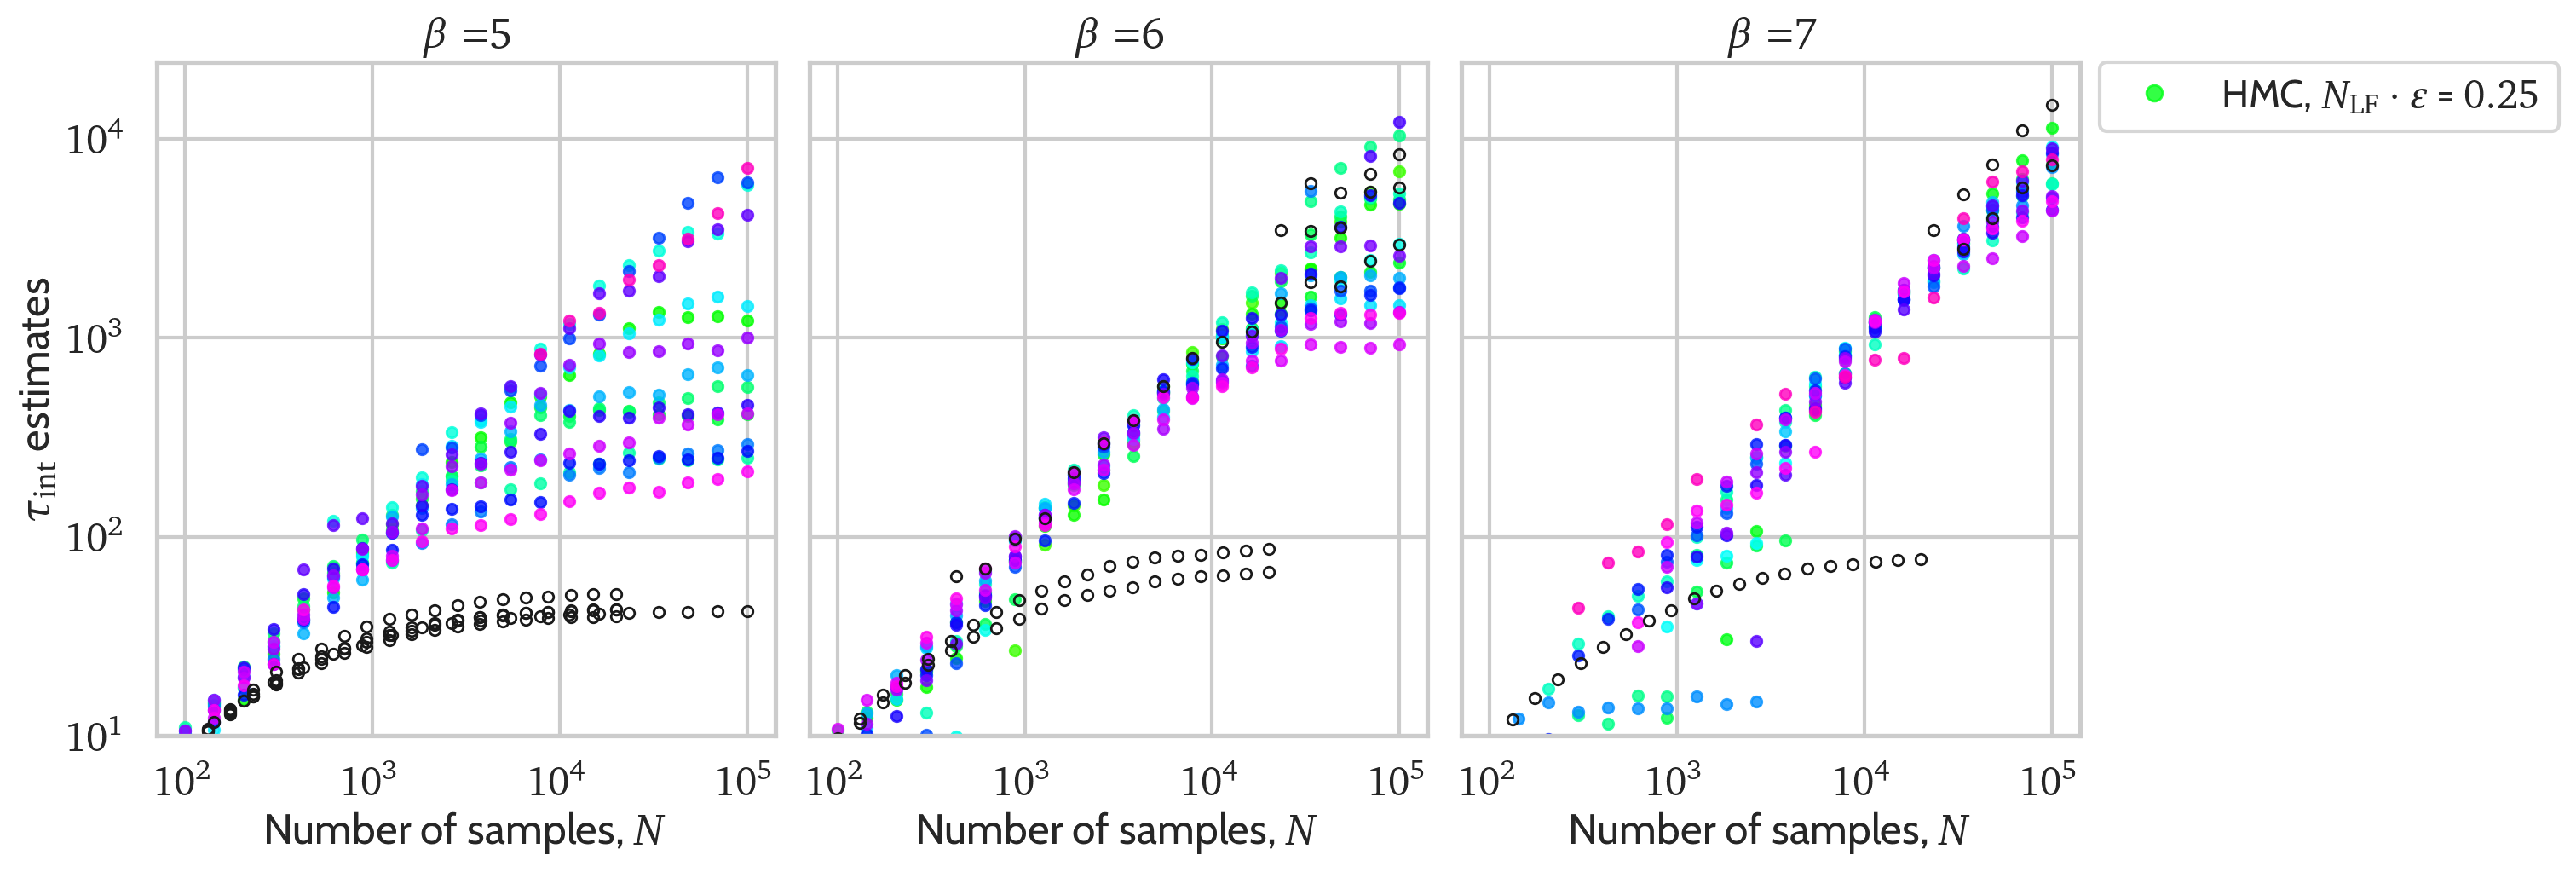

In [155]:
from config import PLOTS_DIR

tstr = io.get_timestamp('%Y-%m-%d')
tint_plots_dir = os.path.join(PLOTS_DIR, 'tau_int_plots', tstr)
io.check_else_make_dir(tint_plots_dir)

num_figs = len(betas)
fig, axes = plt.subplots(ncols=num_figs, sharey='row', sharex=True, figsize=(15, 5), constrained_layout=True)

for ax, beta in zip(axes, betas):
    plot_autocorrs(beta, ldata_[beta], hdata[beta],
                   ax=ax, labels=(beta == 5.),
                   cmap='gist_rainbow')
    
_ = axes[0].set_ylabel(r"$\tau_{\mathrm{int}}$ estimates")
_ = axes[-1].legend(loc='best', bbox_to_anchor=(1.0, 1.03), markerscale=1.5)
for ax in axes:
    _ = ax.set_ylim((10, ax.get_ylim()[-1]))
    _ = ax.set_xlabel(r"Number of samples, $N$")

#x = np.arange(1, 2.5e4, 0.1)
#y = x / 50.
#for ax in axes:
#    _ = ax.set_ylim(8, ax.get_ylim()[1])
#    _ = ax.plot(x, y, 'r--', label=r"$N/50$")
    
#plt.tight_layout()
outfile = os.path.join(tint_plots_dir, 'tau_int_scatter.png')
print(f'Saving figure to: {outfile}')
plt.savefig(outfile, dpi=400, bbox_inches='tight')
#_ = axes[-1].legend(loc='best', bbox_to_anchor=(1.0, 1.04))
#plt.colorbar()
#ValueError: Colormap BrGG is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r


In [156]:
tint_data = {}
for beta in betas:
    tint_data[beta] = {
        'l2hmc': {},
        'hmc': {},
    }
    l2hmc_data = tint_l2hmc[beta]
    for key, val in l2hmc_data.items():
        if np.isfinite(val['tau_int'][-1]):
            tint_data[beta]['l2hmc'][key] = val['tau_int'][-1]
        
    hmc_data = tint_hmc[beta]
    for key, val in hmc_data.items():
        if np.isfinite(val['tau_int'][-1]):
            tint_data[beta]['hmc'][key] = val['tau_int'][-1]

In [157]:
tint_data[5.0]['hmc'] = {k: v for k, v in tint_data[5.0]['hmc'].items() if k[0] * k[1] < 6}
tint_data[5.0]['hmc']

{(15, 0.05000000447034836): 651.1854066001031,
 (20, 0.20000000298023224): 457.4854834854316,
 (25, 0.05000000074505806): 416.50378739025905,
 (15, 0.15000000596046448): 293.00603150154086,
 (15, 0.02500000223517418): 1436.2758749045468,
 (20, 0.10000000149011612): 248.27947537464215,
 (10, 0.10000000149011612): 535.7921782099966,
 (20, 0.15000002086162567): 270.2960513070666,
 (20, 0.25): 4140.643104643261,
 (10, 0.05000000074505806): 1113.832950924613,
 (10, 0.20000000298023224): 900.7954236249656,
 (25, 0.02500000037252903): 997.9168947013083,
 (25, 0.15000000596046448): 212.2684980485613,
 (20, 0.02500000037252903): 1217.7216191818168,
 (15, 0.25): 6042.801669777861,
 (10, 0.15000000596046448): 564.9713924783193,
 (20, 0.05000000074505806): 411.89489944993306,
 (10, 0.25): 5860.270828546801}

In [158]:
for beta in betas:
    ldata = tint_data[beta]['l2hmc']
    if lata

SyntaxError: invalid syntax (<ipython-input-158-42aa4aa83467>, line 3)

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/2020-12-20/tau_int_scatter_beta70.png


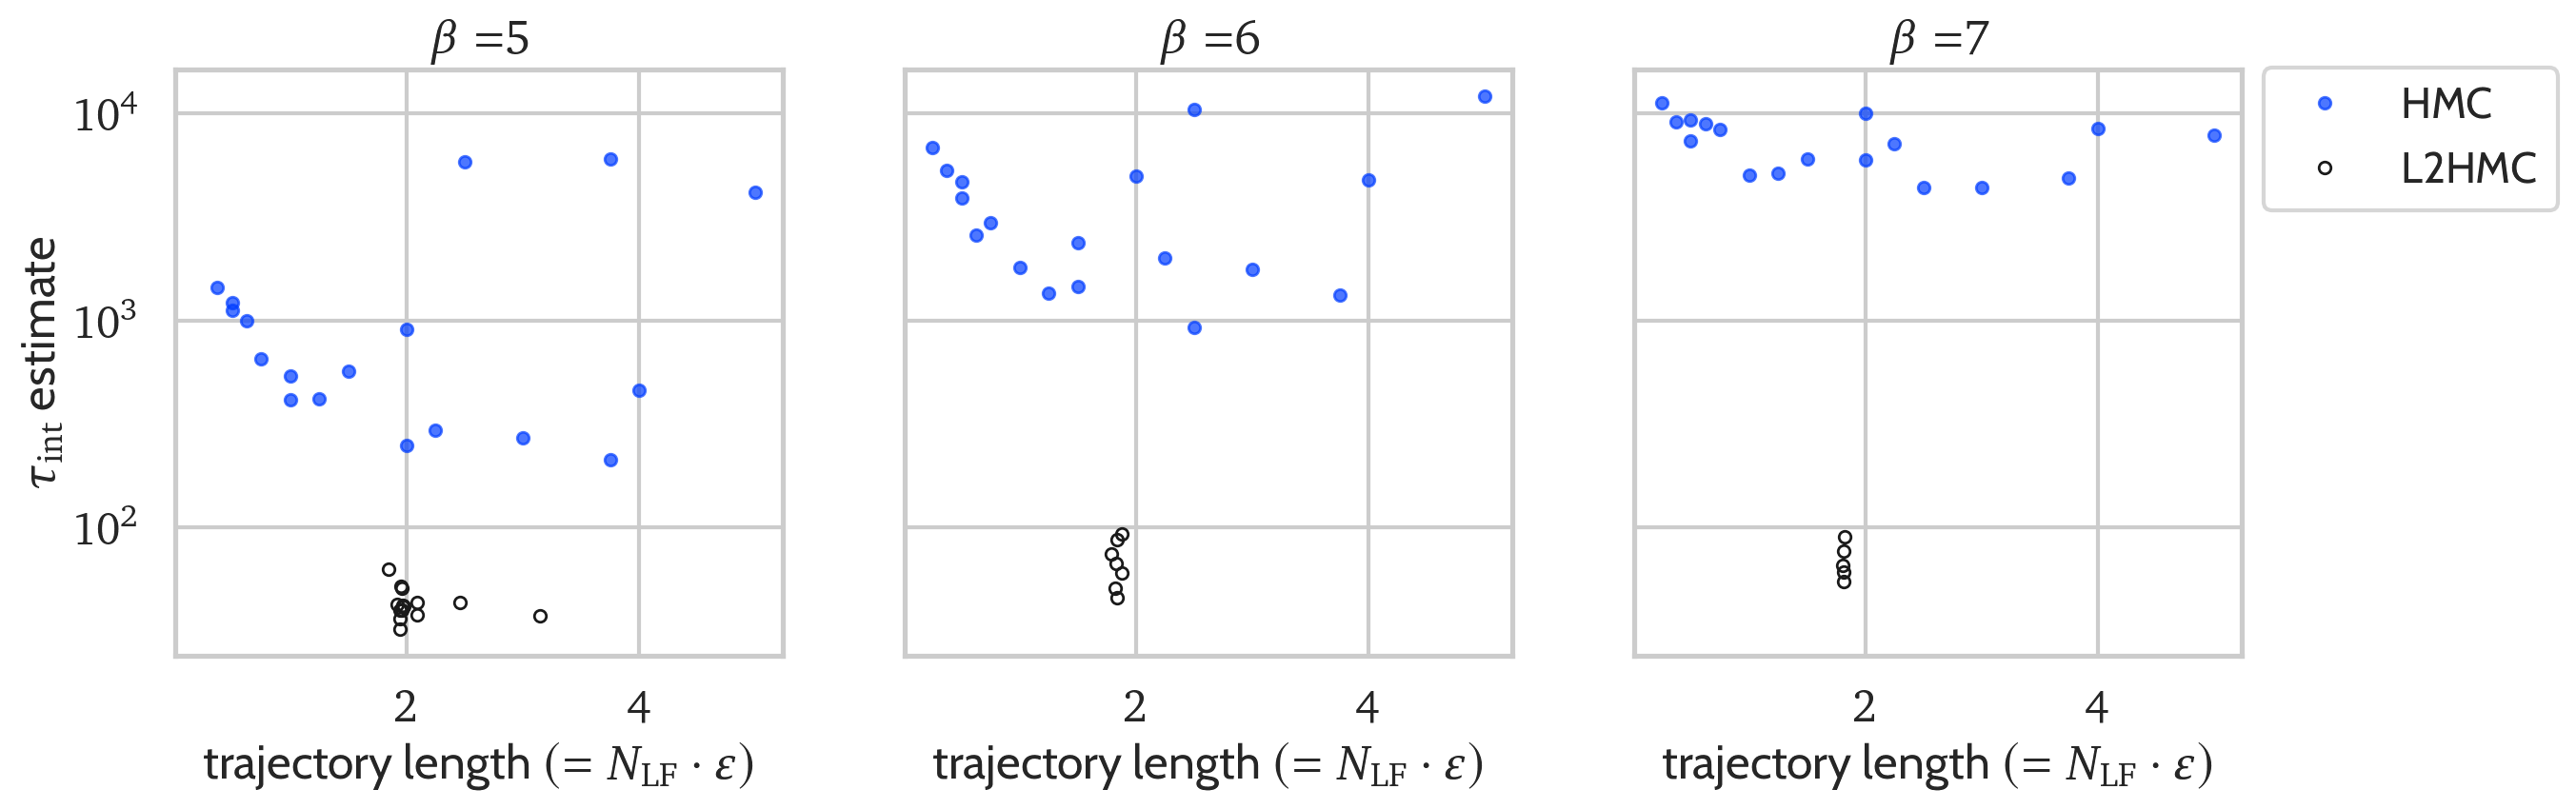

In [184]:
best_l2hmc = {}
best_hmc = {}
#worst_l2hmc = {}
worst_hmc = {}
err_l2hmc = {}
err_hmc = {}
avg_l2hmc = {}
avg_hmc = {}

num_plots = len(list(tint_data.keys()))
fig, axes = plt.subplots(ncols=num_plots, sharey='row', sharex=True, figsize=(14, 4))
for idx, (key, val) in enumerate(tint_data.items()):
    ax = axes[idx]
    beta = key
    
    hmc_data = val['hmc']
    #hmc_arr = np.array([i for i in list(hmc_data.values()) if i > 10])
    hmc_arr = np.array(list(hmc_data.values()))
    hmc_arr = hmc_arr[hmc_arr > 100]
    hmc_avg = np.mean(hmc_arr)
    hmc_err = np.std(hmc_arr)
    err_hmc[key] = hmc_err
    avg_hmc[key] = hmc_avg
    for jdx, (k, v) in enumerate(hmc_data.items()):
        if v < 10:
            continue
        label = 'HMC' if jdx == 0 else None
        lf, eps = k
        traj_len = lf * eps
        
        
        _ = ax.plot(traj_len, v, '.', color='C0', label=label, alpha=0.7, lw=0.8)
    
    l2hmc_data = val['l2hmc']
    l2hmc_arr = np.array([i for i in list(l2hmc_data.values()) if i < 100])
    l2hmc_avg = np.mean(l2hmc_arr)
    l2hmc_err = np.std(l2hmc_arr)
    err_l2hmc[key] = l2hmc_err
    avg_l2hmc[key] = l2hmc_avg
    # err_l2hmc[key] = np.std(np.array(list(l2hmc_data.values())))
    # avg_l2hmc[key] = np.mean(np.array(list(l2hmc_data.values())))
    #best = np.inf
    for jdx, (k, v) in enumerate(l2hmc_data.items()):
        if v > 110:
            continue
            
        label = 'L2HMC' if jdx == 0 else None
        lf, eps = k
        traj_len = lf * eps
        
        _ = ax.plot(traj_len, v, '.', label=label, color='k', fillstyle='none')
        
    _ = ax.set_xlabel('trajectory length ' + r"$(=N_{\mathrm{LF}} \cdot \varepsilon)$")
    _ = ax.set_yscale('log')
    _ = ax.set_title(r"$\beta=$" + beta_str[beta])
    if idx == 0:
        _ = ax.set_ylabel(r"$\tau_{\mathrm{int}}$ estimate")
    if idx == num_plots - 1:
        _ = ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.04))
outfile = os.path.join(tint_plots_dir, f'tau_int_scatter_beta{beta}'.replace('.', '') + '.png')
print(f'Saving figure to: {outfile}')
plt.savefig(outfile, dpi=400, bbox_inches='tight')

Saving figure to: /Users/saforem2/l2hmc-qcd/plots/tau_int_plots/2020-12-20/tau_int_vs_beta.png


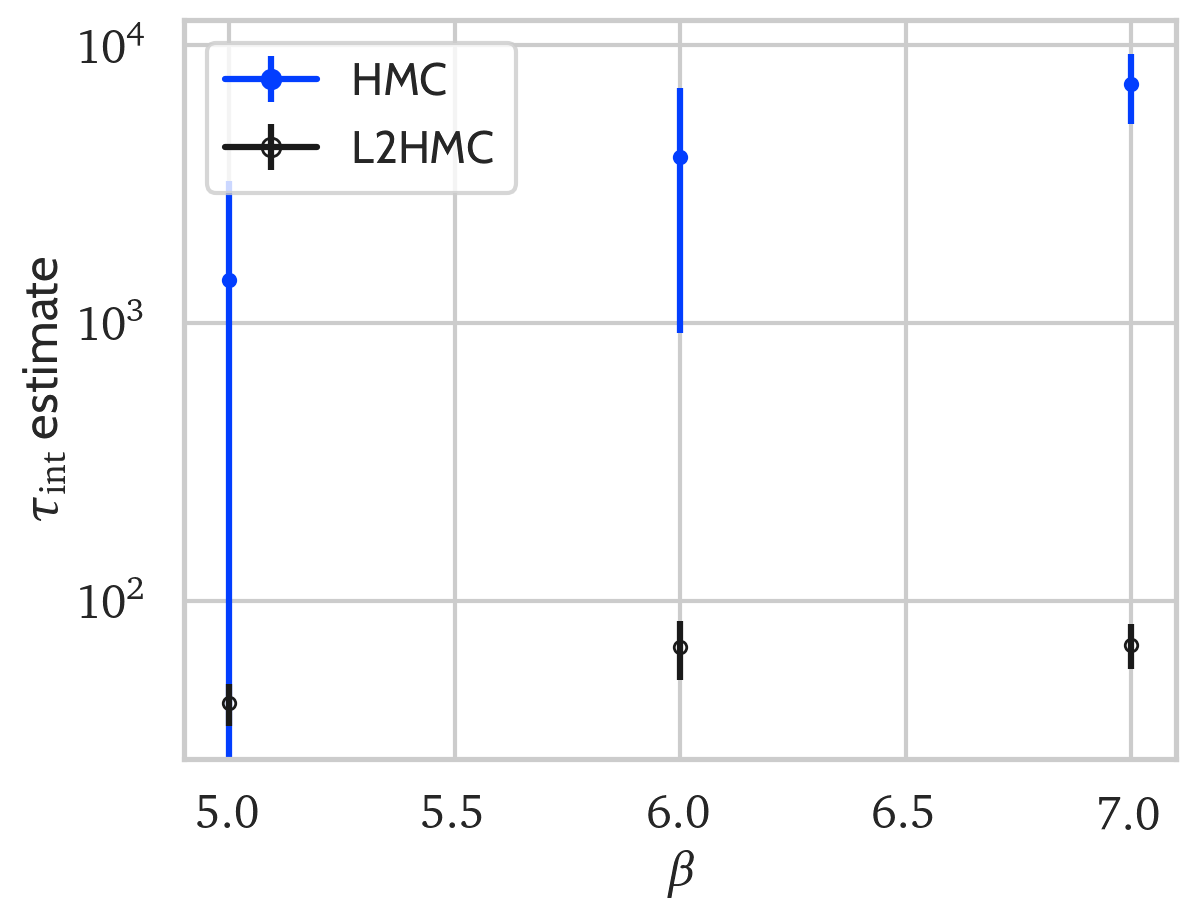

In [185]:
sns.set_style('whitegrid')

fig, ax = plt.subplots()
for idx, (key, val) in enumerate(avg_hmc.items()):
    label = 'HMC' if idx == 0 else None
    _ = ax.errorbar(key, val, yerr=err_hmc[key], marker='.', ls='-', color='C0', label=label)
    #_ = ax.errorbar(key, val, marker='.', ls='-', color='C0', label=label)
    
for idx, (key, val) in enumerate(avg_l2hmc.items()):
    label = 'L2HMC' if idx == 0 else None
    _ = ax.errorbar(key, val, yerr=err_l2hmc[key], marker='.', color='k', ls='-', fillstyle='none', label=label)
    #_ = ax.plot(key, val, marker='.', color='k', ls='-', fillstyle='none', label=label)
    
_ = ax.set_yscale('log')
_ = ax.set_xlabel(r"$\beta$")
_ = ax.set_ylabel(r"$\tau_{\mathrm{int}}$ estimate")
#_ = ax.set_title(r"$\beta=$" + beta_str[beta])
_ = ax.legend(loc='upper left', markerscale=1.5)
outfile = os.path.join(tint_plots_dir, f'tau_int_vs_beta.png')
print(f'Saving figure to: {outfile}')
plt.savefig(outfile, dpi=400, bbox_inches='tight')


In [186]:
#y = q[None, :]
y = qarr
#y = qarr[0]
print(y.shape)
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
#gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    #gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])
    
    
y_hmc = qarr_hmc
#y = qarr[0]
print(y_hmc.shape)
# Compute the estimators for a few different chain lengths
N_hmc = np.exp(np.linspace(np.log(100), np.log(y_hmc.shape[1]), 10)).astype(int)
#gw2010_hmc = np.empty(len(N_hmc))
new_hmc = np.empty(len(N_hmc))
for i, n in enumerate(N_hmc):
    #gw2010_hmc[i] = autocorr_gw2010(y_hmc[:, :n])
    new_hmc[i] = autocorr_new(y_hmc[:, :n])

# Plot the comparisons
#plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="L2HMC")
plt.loglog(N_hmc, new_hmc, "o-", label="HMC")
ylim = plt.gca().get_ylim()
#plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
#plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

(2048, 4000)


NameError: name 'qarr_hmc' is not defined

In [ ]:
q_hmc[5.0].keys()

In [ ]:
q_hmc[5.0][(20, 0.05)]

In [16]:
dqi_stats_l2hmc, dqi_avgs_l2hmc, dqi_errs_l2hmc = dq_stats(dqi_l2hmc, reps=100, therm_frac=0.5)

------------------------------------------------------------------------------------------------------------------------
key: 5.0...
.....key, val.shape: (10, 0.19424471), (5000, 2048)
.....key, therm_arr.shape: (10, 0.19424471), (2500, 2048)
.....key, avg: (10, 0.19424471), 0.12506499886512756 +/- -0.014034612425984958
.....key, val.shape: (10, 0.19657207), (5000, 2048)
.....key, therm_arr.shape: (10, 0.19657207), (2500, 2048)
.....key, avg: (10, 0.19657207), 0.10240905731916428 +/- -0.012410583155360652
------------------------------------------------------------------------------------------------------------------------
key: 6.0...
.....key, val.shape: (10, 0.18413678), (5000, 2048)
.....key, therm_arr.shape: (10, 0.18413678), (2500, 2048)
.....key, avg: (10, 0.18413678), 0.07840519398450851 +/- -0.010606209880734237
.....key, val.shape: (10, 0.187783), (5000, 2048)
.....key, therm_arr.shape: (10, 0.187783), (2500, 2048)
.....key, avg: (10, 0.187783), 0.05909442901611328 +/- -0.009

In [17]:
dqi_stats_hmc, dqi_avgs_hmc, dqi_errs_hmc = dq_stats(dqi_hmc, reps=100, therm_frac=0.5)

------------------------------------------------------------------------------------------------------------------------
key: 5.0...
.....key, val.shape: (20, 0.05), (5000, 512)
.....key, therm_arr.shape: (20, 0.05), (2500, 512)
.....key, avg: (20, 0.05), 0.014459621161222458 +/- -0.004154317691268261
.....key, val.shape: (20, 0.025), (5000, 512)
.....key, therm_arr.shape: (20, 0.025), (2500, 512)
.....key, avg: (20, 0.025), 0.007725532166659832 +/- -0.003002356036324596
.....key, val.shape: (20, 0.25), (5000, 512)
.....key, therm_arr.shape: (20, 0.25), (2500, 512)
.....key, avg: (20, 0.25), 0.0006556513835676014 +/- -0.000562246875882748
.....key, val.shape: (15, 0.1), (5000, 512)
.....key, therm_arr.shape: (15, 0.1), (2500, 512)
.....key, avg: (15, 0.1), 0.017396004870533943 +/- -0.004640591166366902
.....key, val.shape: (20, 0.1), (5000, 512)
.....key, therm_arr.shape: (20, 0.1), (2500, 512)
.....key, avg: (20, 0.1), 0.02262517437338829 +/- -0.005283789071881982
.....key, val.shape:

.....key, avg: (25, 0.3), 0.0 +/- 0.0
.....key, val.shape: (10, 0.05), (5000, 512)
.....key, therm_arr.shape: (10, 0.05), (2500, 512)
.....key, avg: (10, 0.05), 0.00020307203521952033 +/- -0.00019996805792548837
.....key, val.shape: (15, 0.25), (5000, 512)
.....key, therm_arr.shape: (15, 0.25), (2500, 512)
.....key, avg: (15, 0.25), 9.007033077068627e-05 +/- -9.007032933992844e-05
.....key, val.shape: (10, 0.15), (5000, 512)
.....key, therm_arr.shape: (10, 0.15), (2500, 512)
.....key, avg: (10, 0.15), 0.00018235755851492286 +/- -0.00018028154873239166
.....key, val.shape: (25, 0.05), (5000, 512)
.....key, therm_arr.shape: (25, 0.05), (2500, 512)
.....key, avg: (25, 0.05), 0.00040710068424232304 +/- -0.0003882862109917437
.....key, val.shape: (10, 0.1), (5000, 512)
.....key, therm_arr.shape: (10, 0.1), (2500, 512)
.....key, avg: (10, 0.1), 0.0002535659004934132 +/- -0.0002473854514619775
.....key, val.shape: (25, 0.1), (5000, 512)
.....key, therm_arr.shape: (25, 0.1), (2500, 512)
.....k

.....key, avg: (10, 0.025), 0.009911634027957916 +/- -0.003393537432424409
.....key, val.shape: (25, 0.3), (5000, 512)
.....key, therm_arr.shape: (25, 0.3), (2500, 512)
.....key, avg: (25, 0.3), 1.0687499525374733e-05 +/- -1.0687498956940544e-05
.....key, val.shape: (20, 0.1), (5000, 512)
.....key, therm_arr.shape: (20, 0.1), (2500, 512)
.....key, avg: (20, 0.1), 0.05803427845239639 +/- -0.0085259897807191
.....key, val.shape: (15, 0.3), (5000, 512)
.....key, therm_arr.shape: (15, 0.3), (2500, 512)
.....key, avg: (15, 0.3), 0.0003041797608602792 +/- -0.0003036992515365718
.....key, val.shape: (15, 0.25), (5000, 512)
.....key, therm_arr.shape: (15, 0.25), (2500, 512)
.....key, avg: (15, 0.25), 0.0046217842027544975 +/- -0.0023142495529257603
.....key, val.shape: (15, 0.15), (5000, 512)
.....key, therm_arr.shape: (15, 0.15), (2500, 512)
.....key, avg: (15, 0.15), 0.04855457693338394 +/- -0.007924778551205235
.....key, val.shape: (15, 0.05), (5000, 512)
.....key, therm_arr.shape: (15, 0.0

.....key, avg: (20, 0.2), 0.10552404075860977 +/- -0.012289390101796013
.....key, val.shape: (15, 0.25), (5000, 512)
.....key, therm_arr.shape: (15, 0.25), (2500, 512)
.....key, avg: (15, 0.25), 0.02198203094303608 +/- -0.005783857405650097
.....key, val.shape: (20, 0.15), (5000, 512)
.....key, therm_arr.shape: (20, 0.15), (2500, 512)
.....key, avg: (20, 0.15), 0.1553160399198532 +/- -0.014290220741895605
.....key, val.shape: (15, 0.1), (5000, 512)
.....key, therm_arr.shape: (15, 0.1), (2500, 512)
.....key, avg: (15, 0.1), 0.11269626021385193 +/- -0.011744904098304683
.....key, val.shape: (25, 0.05), (5000, 512)
.....key, therm_arr.shape: (25, 0.05), (2500, 512)
.....key, avg: (25, 0.05), 0.11259154230356216 +/- -0.011625520487723404
.....key, val.shape: (25, 0.1), (5000, 512)
.....key, therm_arr.shape: (25, 0.1), (2500, 512)
.....key, avg: (25, 0.1), 0.1821298748254776 +/- -0.015154401064501138
.....key, val.shape: (20, 0.25), (5000, 512)
.....key, therm_arr.shape: (20, 0.25), (2500, 

In [69]:
%store q_hmc
%store q_l2hmc
%store dqi_hmc
%store dqi_l2hmc

Stored 'q_hmc' (AttrDict)
Stored 'q_l2hmc' (AttrDict)
Stored 'dqi_hmc' (AttrDict)
Stored 'dqi_l2hmc' (AttrDict)


In [73]:
hmc_df = pd.DataFrame().from_dict({
    key: {
        (k[0], k[1]): np.squeeze(v.flatten()) for k, v in val.items()
    } for key, val in q_hmc.items()
})
hmc_df.head()

5.0  \
20 0.050  [-1.0000002, 1.9999996, -5.3123694e-07, -1.062...   
   0.025  [-1.0000006, -7.0, -3.0, 2.0000007, -6.071279e...   
   0.250  [3.7945494e-08, -1.8972747e-07, -1.0000004, 2....   
15 0.100  [-0.99999976, -1.5178198e-07, 0.9999998, -0.99...   
20 0.100  [-1.0000001, -1.1383648e-07, -6.071279e-07, 0....   

                                                        7.0  \
20 0.050  [-1.9999992, -1.0000001, 0.9999996, 0.99999946...   
   0.025  [1.0000002, -3.0000002, -4.0000005, -1.9999995...   
   0.250  [-1.0000001, -0.99999946, 4.9999995, -3.000000...   
15 0.100  [0.99999976, -1.0000005, 0.99999994, 0.9999996...   
20 0.100  [0.99999946, 2.0, 2.0, 0.9999992, -1.9999996, ...   

                                                        6.0  \
20 0.050  [-1.0000002, -1.9999992, -1.1383648e-07, -2.00...   
   0.025  [-0.99999994, -2.0000002, 1.9999999, -2.0, -1....   
   0.250  [0.99999994, -0.99999994, 0.99999946, -3.00000...   
15 0.100  [1.0, 0.9999996, -1.0000007, 9.865828e-07, -1....   
20 0.100  [3.7945494e-08, 2.9999993, -2.0000007, 0.99999...   

                                                        4.5  \
20 0.050  [-3.7945495e-07, 1.9999999, 1.9999999, -3.0356...   
   0.025  [1.9999999, 7.589099e-08, 1.9999994, -3.999999...   
   0.250  [-1.0, 3.0000005, 0.99999994, -5.8815516e-07, ...   
15 0.100  [-1.9999996, -7.589099e-07, 0.9999996, 0.99999...   
20 0.100  [-2.0000002, 1.0000002, -6.2610064e-07, -1.999...   

                                                        5.5  \
20 0.050  [-2.2767296e-07, -1.0000002, 0.9999995, -1.214...   
   0.025  [-0.9999997, 1.0000001, -1.0000001, -2.0000002...   
   0.250  [-1.0000001, -6.450734e-07, -2.0000005, 1.0, 2...   
15 0.100  [-2.0000002, -0.99999946, 1.9999995, -2.999999...   
20 0.100  [-8.537736e-07, -1.0000008, 1.0000002, -1.0000...   

                                                        4.0  3.0  
20 0.050  [-1.0000005, -3.7945494e-08, -0.9999995, -6.45...  NaN  
   0.025                                                NaN  NaN  
   0.250  [-3.4150943e-07, -2.0000002, 0.99999946, 5.312...  NaN  
15 0.100  [-1.9999996, 1.9999996, 2.9999995, 4.553459e-0...  NaN  
20 0.100  [1.0000002, -2.0000002, -1.0, 0.99999976, -3.0...  NaN

In [78]:
l2hmc_df = xr.DataArray({
    key: {
        (k[0], k[1]): np.squeeze(v.flatten()) for k, v in val.items()
    } for key, val in q_l2hmc.items()
})
l2hmc_df

<xarray.DataArray ()>
array(<built-in method values of dict object at 0x1042d35780>,
      dtype=object)

In [82]:
import xarray as xr
from utils.data_utils import therm_arr

therm_frac = 0.25

#hmc_xarr = {}
hmc_xarr = []
for beta, data in q_hmc.items():
    if beta not in q_l2hmc.keys():
        continue
        
    for k, v in data.items():
        num_steps, num_chains = v.shape
        arr, steps = therm_arr(v, therm_frac=therm_frac)
        chains = np.arange(num_chains)
        coords = {
            'chain': chains,
            'draw': steps,
            'beta': beta,
            'leapfrog': k[0],
            'eps': k[1],
        }
        hmc_xarr.append(xr.DataArray(arr.T, dims=['chain', 'draw'], coords=coords))

In [84]:
xr.merge(hmc_xarr)

ValueError: unable to convert unnamed DataArray to a Dataset without providing an explicit name

In [ ]:
hmc_xarr

In [1]:
import xarray as xr

dataset = xr.Dataset({'l2hmc': l2hmc_df, 'hmc': hmc_df})
dataset

NameError: name 'l2hmc_df' is not defined

### Save boostrapped tunneling rate stats to avoid having to recompute

In [18]:
from config import LOGS_DIR

timestamp = io.get_timestamp()
date = io.get_timestamp('%Y-%m-%d')
outdir = os.path.join(LOGS_DIR, 'tunneling_rates', date)
datadir = os.path.join(outdir, 'data')
figsdir = os.path.join(outdir, 'figs')
io.check_else_make_dir([outdir, datadir, figsdir])

# +-------+
# | L2HMC |
# +-------+
intfile_l2hmc = os.path.join(f'dq_int_stats_l2hmc_{timestamp}.z')
io.savez(dqi_stats_l2hmc, intfile_l2hmc, name='dq_int_stats_l2hmc')

#sinfile_l2hmc = os.path.join(f'dq_sin_stats_l2hmc_{timestamp}.z')
#io.savez(dqs_stats_l2hmc, sinfile_l2hmc, name='dq_sin_stats_l2hmc')

# +-----+
# | HMC |
# +-----+
intfile_hmc = os.path.join(f'dq_int_stats_hmc_{timestamp}.z')
io.savez(dqi_stats_hmc, intfile_hmc, name='dq_int_stats_hmc')

#sinfile_hmc = os.path.join(f'dq_sin_stats_hmc_{timestamp}.z')
#io.savez(dqs_stats_hmc, sinfile_hmc, name='dq_sin_stats_hmc')

Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09
Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09/data
Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09/figs
Saving dq_int_stats_l2hmc to /Users/saforem2/l2hmc-qcd/l2hmc-qcd/notebooks/dq_int_stats_l2hmc_2020-12-09-235915.z.
Saving dq_int_stats_hmc to /Users/saforem2/l2hmc-qcd/l2hmc-qcd/notebooks/dq_int_stats_hmc_2020-12-09-235915.z.


In [19]:
from config import LOGS_DIR
import utils.file_io as io

outdir = os.path.join(LOGS_DIR, 'tunneling_rates', date)
datadir = os.path.join(outdir, 'data')
figsdir = os.path.join(outdir, 'figs')

In [20]:
def load_dq_data(datafiles):
    data = {}
    for datafile in datafiles:
        print(f'Loading data from: {datafile}...')
        key = '_'.join(datafile.split('/')[-1].split('_')[:4])
        val = io.loadz(datafile)
        data[key] = val
    return  data

### Scatter plot of $\langle \delta\mathcal{Q}\rangle$ vs $\varepsilon$ for HMC, L2HMC

In [21]:
dqi_stats_l2hmc = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))
dqih = dict(sorted(dqi_stats_hmc.items(), key=lambda x: x[0]))
dqil = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))

print(f'hmc keys: {dqi_stats_hmc.keys()}')
print(f'l2hmc keys: {dqi_stats_l2hmc.keys()}')

hmc keys: dict_keys([5.0, 7.0, 6.0, 4.5, 5.5, 4.0, 3.0])
l2hmc keys: dict_keys([5.0, 6.0, 7.0])


In [22]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [23]:
%matplotlib inline

In [35]:
%matplotlib notebook

In [37]:
dqih.keys()

dict_keys([3.0, 4.0, 4.5, 5.0, 5.5, 6.0, 7.0])

In [38]:
dqih[5.0].keys()

dict_keys([(20, 0.05), (20, 0.025), (20, 0.25), (15, 0.1), (20, 0.1), (15, 0.2), (25, 0.2), (20, 0.3), (25, 0.025), (15, 0.05), (25, 0.3), (15, 0.3), (20, 0.2), (15, 0.25), (25, 0.25), (25, 0.15), (20, 0.15), (15, 0.025), (15, 0.15), (25, 0.05), (10, 0.025), (25, 0.1), (10, 0.3), (10, 0.1), (10, 0.2), (10, 0.25), (10, 0.05), (10, 0.15)])

In [ ]:
dqih[]

In [50]:
axes1.shape

(3,)

In [51]:
axes_grid.shape

(2, 3)

In [2]:
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
from config import MARKERS, LOGS_DIR, FIGSIZE, TEX_FIGURES_DIR, PLOTS_DIR
from utils.plotting_utils import set_size

H, W = FIGSIZE

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')
#plt.Axes.set_yticklabels()

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=(
   r"""
   \usepackage{amsmath}
   \usepackage[sups]{XCharter}
   \usepackage[scaled=1.04,varqu,varl]{inconsolata}
   \usepackage[type1]{cabin}
   \usepackage[charter,vvarbb,scaled=1.07]{newtxmath}
   \usepackage[cal=boondoxo]{mathalfa}
   """
))

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = ['x', '', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

leapfrogs_l2hmc = [10]  # , 15, 20]
leapfrogs_hmc = [10, 15, 20, 25, 30]
keep_betas = [5., 6., 7.]
eps_cond = lambda eps: eps < 0.29


beta_dict = {
    2.0: r"$2$",
    3.0: r"$3$",
    4.0: r"$4$",
    4.5: r"$4.5$",
    5.0: r"$5$",
    6.0: r"$6$",
    7.0: r"$7$",
}

lf_dict = {
    10: r"$10$",
    15: r"$15$",
    20: r"$20$",
    25: r"$25$",
    30: r"$30$",
}

plot_kwargs = {
    'markersize': 8.,
    'lw': 2.,
    'alpha': 1.,
    #'marker': '.',
}

plot_kwargs_hmc = copy.deepcopy(plot_kwargs)
plot_kwargs_l2hmc = copy.deepcopy(plot_kwargs)

plot_kwargs_l2hmc.update({'ls': '', 'color': 'k', 'marker': 'o'})
plot_kwargs_hmc.update({'ls': '-', 'marker': '.'})

lf_colors = plt.cm.get_cmap('Greys', 16)
lf_colors_l2hmc = 10 * ['#87ff00']

HMC_COLORS = np.array(9 * ['C1'])
L2HMC_COLORS = np.array(9 * ['C0'])

labels = {
    'hmc_int': r"HMC",
    'hmc_sin': r"HMC (sin)",
    'l2hmc_int': r"L2HMC",
    'l2hmc_sin': r"L2HMC (sin)",
}


subfig_idxs = ['(a.) ', '(b.) ', '(c.) ', '(d.) ']

dqih = dict(sorted(dqi_stats_hmc.items(), key=lambda x: x[0]))
dqil = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))

figsize = set_size(subplots=(2, 3))

#widths = [2, 3, 1.5]
#heights = [1, 3, 2]
#gs_kw = dict(width_ratios=widths, height_ratios=heights)
#fig6, f6_axes = plt.subplots(ncols=3, nrows=3, constrained_layout=True,
#        gridspec_kw=gs_kw)

gs_kw = {
    'height_ratios': [2.5, 1],
}

fig, axes_grid = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), constrained_layout=True,
                              sharex='col',
                              gridspec_kw=gs_kw)
axes = axes_grid[0, :].flatten()
axes1 = axes_grid[1, :].flatten()


# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
# axins = inset_axes(axes[-1], width="75%", height="27%", loc='upper left', borderpad=0.4)
# axins1 = inset_axes(axes[1], width="75%", height="27%", loc='upper left', borderpad=0.4)


#axins = inset_axes(axes[-1], width=5., height=1.5, bbox_to_anchor=(1.0, 1.01))
# Create an inset outside the axes

# axins = inset_axes(axes[-1], width="100%", height="100%",
#                    bbox_to_anchor=(1.05, .6, .5, .4),
#                    bbox_transform=axes[-1].transAxes, loc=2, borderpad=0)

# axins3 = inset_axes(ax3, width="100%", height="100%",
#                     bbox_to_anchor=(.7, .5, .3, .5),
#                     bbox_transform=ax3.transAxes)
#axins = inset_axes(axes[-1], width="100%", height="100%",
#                   bbox_to_anchor=(.7, .5, .3, .5),
#                   #bbox_to_anchor=(1.05, 0.1, .4, .6),
#                   bbox_transform=axes[-1].transAxes, borderpad=0.5)
#axins.tick_params(left=False, right=True, labelleft=False, labelright=True)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
#mark_inset(axes[-1], axins, loc1=2, loc2=4, fc="none", alpha=0.7, ec='0.3', zorder=-20)


#axins = zoomed_inset_axes(axes[-1], 1, loc='upper left') #bbox_to_anchor=(1.0, 0), loc='upper left')  # zoom = 6

from mpl_toolkits.axes_grid1 import Grid

idx = 0
for kih, vih in dqih.items():
    #fig, ax = plt.subplots(constrained_layout=True)
    ax1 = axes1[idx]
    beta = kih
    if beta < 5.0 or beta not in keep_betas:
        continue
    # ====
    # NOTE:
    # vih = {
    #    (leapfrogs, eps): {
    #        'avg': avg, 'avg_std': avg_std,
    #        'err': err, 'err_std': err_std,
    #        'min': min, 'max': max,
    #    }
    # }
    #if beta not in dqi_stats_l2hmc.keys():
    #    continue
    try:
        ax = axes[idx]
    except IndexError or beta not in dqi_stats_l2hmc.keys():
        continue
        
    def get_plot_data(d):
        x = []
        y = []
        y_err = []
        for k, v in d.items():
            num_steps, eps = k
            if eps_cond(eps):
                x.append(eps)
                y.append(v['avg'])
                y_err.append(v['err'])
            
        return x, y, y_err
    
    def share_yaxes(row, base=0):
        
        #ylim = row[base].get_ylim()
        #yticklabels = ax.get_yticklabels()
        _ax = row[base]
        ylim = _ax.get_ylim()
        y0, y1 = ylim
        yticks = _ax.get_yticks()
        yticklabels = _ax.get_yticklabels()
        
        for ax in row[1:]:
            _ = ax.set_ylim(ylim)
            _ = ax.set_yticklabels([])
            _ = ax.set_yticks(yticks)

        return row
    
    dqil = dqi_stats_l2hmc.get(beta, None)
    if dqil is not None:
        # +-----------------------------------------------------+
        #   NOTE:
        #   ====
        #     dqil_ = {
        #         (Nlf, eps0): {'avg': ..., 'err': ..., },
        #         (Nlf, eps1): {'avg': ..., 'err': ..., },
        #     }
        # +-----------------------------------------------------+
        #dqil_ = sorted(dqil.items(), key=lambda x: x[0])
        _vil = dict(sorted(dqil.items(), key=lambda x: x[0][1]))
        _vil_ = {lf: {} for lf in leapfrogs_l2hmc}
        for k, v in _vil.items():
            for lf in leapfrogs_l2hmc:
                if k[0] == lf:
                    _vil_[lf][k] = v
                
        for jdx, lf in enumerate(leapfrogs_l2hmc):
            if lf not in _vil_.keys():
                continue
            if idx == 2:
                label = r"$N_{\mathrm{LF}} = $" + f'{lf_dict[lf]}, ' + 'L2HMC'
                #_ = axins.errorbar(xil, yil, yil_err, label=label, **plot_kwargs_l2hmc)
            else:
                label = None
            xil, yil, yil_err = get_plot_data(dict(sorted(_vil_[lf].items(), key=lambda x: x[0][1])))
            _ = ax.errorbar(xil, yil, yil_err, label=label, fillstyle='none', **plot_kwargs_l2hmc)
    
    _vih = dict(sorted(vih.items(), key=lambda x: x[0][1]))
    _vih_ = {lf: {} for lf in leapfrogs_hmc}
    for k, v in _vih.items():
        for lf in leapfrogs_hmc:
            if k[0] == lf:
                _vih_[lf][k] = v
    
    for jdx, lf in enumerate(leapfrogs_hmc):
        if lf not in _vih_.keys() or lf == 30:
            continue
            
        xih, yih, yih_err = get_plot_data(dict(sorted(_vih_[lf].items(),
                                                      key=lambda x: x[0][1])))
        if idx == 1:  # right most sub plot
            label =  r"$N_{\mathrm{LF}}=$" + f'{lf_dict[lf]}, ' + 'HMC'
            # _ = axins1.plot(xih, yih, label=label,
            #                 color=lf_colors(2*(jdx + 4)),
            #                 markersize=5., ls='', alpha=1., marker='.')
        if idx == 2:  # right most sub plot
            label =  r"$N_{\mathrm{LF}}=$" + f'{lf_dict[lf]}, ' + 'HMC'
            # _ = axins.plot(xih, yih, label=label,
            #                color=lf_colors(2*(jdx + 4)),
            #                markersize=5., ls='', alpha=1., marker='.')
        else:  # don't bother labeling, no legend
            label = None
            
        _ = ax.errorbar(xih, yih, yih_err,
                        #ls=':', marker='.',
                        label=label, color=COLORS[jdx],
                        **plot_kwargs_hmc)
        _xih_ = xih[:-1]
        _yih_ = yih[:-1]
        _yih_err_ = yih_err[:-1]
        _ = ax1.errorbar(_xih_, _yih_, _yih_err_,
                         capsize=1.5, alpha=0.6,
                         ls='', marker='.',
                         #ls=':', marker='.',
                         label=label, color=COLORS[jdx])  # color=lf_colors(jdx+8),
                         #**plot_kwargs_hmc)

    
        
            
    title_str = ' '.join([r"$\beta=$", beta_dict[beta]])
    _ = ax.set_title(title_str)
    
    timestamp = io.get_timestamp()
    #if idx == 0:
        #_ = ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0), framealpha=0.4, fontsize='small')
        #_ = ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01), framealpha=0.4, fontsize='small')
        #_ = ax.legend(loc='upper left', framealpha=0.4, fontsize='x-small')
    _ = axes[0].set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", rotation='horizontal', ha='right')
    for ax in axes:
        #_ = ax.set_xlabel('')
        _ = ax.tick_params(grid_alpha=0.5)
    for ax in axes1:
        _ = ax.set_xlabel(r"$\varepsilon$")
        _ = ax.tick_params(grid_alpha=0.5)
        _ = ax.set_yscale('log')
        
    # for ax in axes1[1:]:
    #     ylim = ax
    #     yticks = ax.get_yticks()
    #     yticklabels = ax.get_yticklabels()
    #     _ = ax.set_yticks(yticks)
    #     _ = ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})
        
        
        #_ = ax.set(framealpha=0.5)
        #_ = ax.set_xlim((0.0245, 0.255))
        #_ = ax.set_ylim((0, ax.get_ylim()[-1]))
        
    idx += 1
    
    
    
#_ = share_yaxes(axes)

# for ax in axes1[1:]:
#     #_ = ax.set_autoscaley_on(True)
#     yticks = ax.get_yticks()
#     yticklabels = ax.get_yticklabels()
#     _ = ax.set_yticks(yticks)
#     _ = ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})
        
#def share_xaxes(row, base=0):
#    xmin, xmax = row[base].get_xlim()
#    for plot in row:
#        plt.set_xlim((xmin, xmax))
        

    
# ins_xlim = axins.get_xlim()
# ins_ylim = axins.get_ylim()
# x0 = ins_xlim[0] + 0.001
# y0 = ins_ylim[0] - 0.0001
# _ = axins.set_xlim((x0, 0.2101))
# _ = axins.set_ylim((y0, ins_ylim[-1]))
# _ = ax.grid()
# _ = axins.tick_params(right=True, left=False, labelright=True, labelleft=False,
#                       labelbottom=True, bottom=True,
#                       labelsize='x-small', grid_alpha=1.0, color='w', length=0.5)
# _ = axins.yaxis.get_major_locator().set_params(nbins=3)
# _ = axins.xaxis.get_major_locator().set_params(nbins=3)


# ins_xlim = axins1.get_xlim()
# ins_ylim = axins1.get_ylim()
# x0 = ins_xlim[0] + 0.001
# y0 = ins_ylim[0] - 0.0001
# _ = axins1.set_xlim((x0, 0.2101))
# _ = axins1.set_ylim((y0, ins_ylim[-1]))
# _ = axins1.tick_params(right=True, left=False, labelright=True, labelleft=False,
#                       labelbottom=True, bottom=True,
#                       labelsize='x-small', grid_alpha=1., color='w', length=0.5)
# _ = axins1.yaxis.get_major_locator().set_params(nbins=3)
# _ = axins1.xaxis.get_major_locator().set_params(nbins=3)



#_ = axins.tick_params(left=False, right=True, labelleft=False, labelright=True)

    
# x1, x2, y1, y2 = 0.01, 0.12, -0.0005, 0.0005
#_ = axins.set_xlim(0.065, 0.165)
#_ = axins.set_ylim(-0.0005, 0.0010)

# # fix the number of ticks on the inset axes
#_ = axins.xaxis.get_major_locator().set_params(nbins=2)

#_ = plt.setp(axins.get_xticklabels(), visible=False)
#_ = plt.setp(axins.get_yticklabels(), visible=False)
#for ax in axes1:
#    ax.set_yscale('log')
    
   

    #yticklabels = ax.get_yticklabels()
    #ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})

_ = axes[0].legend(loc='upper left', framealpha=0.4, fontsize='x-small')

fname = f'dq_vs_beta'
out_file = os.path.join(PLOTS_DIR, '.'.join([fname, 'pdf']))
head, tail = os.path.split(out_file)
io.check_else_make_dir(head)
print(f'Saving figure to: {out_file}')
_ = plt.savefig(out_file, dpi=600, bbox_inches='tight')

out_file = os.path.join(TEX_FIGURES_DIR, 'tunneling_rates', '.'.join([fname, 'pdf']))
head, tail = os.path.split(out_file)
io.check_else_make_dir(head)
print(f'Saving figure to: {out_file}')
_ = plt.savefig(out_file, dpi=600, bbox_inches='tight')
#plt.show()
#import tikzplotlib
#_ = plt.tight_layout()
#out_file = os.path.join(figsdir, f'dq_lf10_stats_beta_{timestamp}_tikz'.replace('.', '') + '.tex')
#tikzplotlib.clean_figure(fig)
#tikzplotlib.save(out_file)
#_ = fig.suptitle(r"$N_{\mathrm{LF}} = $" + lf_dict[leapfrogs])

#dqsh = sorted(dqs_stats_hmc.items(), key=lambda x: x[0])
#nrows = len(dqi_stats_l2hmc.keys())
#fig, axes = plt.subplots(nrows=2, ncols=3, sharex='col', figsize=(11, 8), constrained_layout=True)
# (4, 3)
#fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6), constrained_layout=True)
#for idx, ((kih, vih), (ksh, vsh)) in enumerate(zip(dqih, dqsh)):
#if idx == 0:
#li_label = labels['l2hmc_int'] + r"$N_{\mathrm{LF}} = $"
#ls_label = labels['l2hmc_sin'] + r"$N_{\mathrm{LF}} = $"
#hs_label = labels['hmc_sin'] + r"$N_{\mathrm{LF}} = $"
#hi_label = labels['hmc_int'] + r"$N_{\mathrm{LF}} = $"
#else:
#    hi_label = hs_label = li_label = ls_label = None


#_vih_ = {k: v for k, v in _vih.items() if k[0] == leapfrogs}


tf.__version__: 1.15.0


NameError: name 'dqi_stats_hmc' is not defined

In [34]:
ax = axes1[0]

In [ ]:
%debug

In [66]:
%matplotlib notebook

In [76]:
%debugkj

> <ipython-input-30-a98819713ef3>(2)<module>()
      1 dqi_stats_l2hmc[3.0] = {
----> 2     k: v for k, v in dqi_stats_l2hmc[3.0].items() if v['avg'] > 0.5
      3 }
      4 dqi_stats_l2hmc

ipdb> q


In [77]:
lf_colors(1)

(0.9282913165266107, 0.9282913165266107, 0.9282913165266107, 1.0)

In [ ]:
plt.legend()

In [70]:
%debug

> <ipython-input-69-11ca2af3b029>(131)<module>()
    129         try:
    130             xih, yih, yih_err = get_plot_data(dict(sorted(_vih_[lf].items(), key=lambda x: x[0][1])))
--> 131             _ = ax.errorbar(xih, yih, yih_err, label=hi_label + f'{lf_dict[lf]}',
    132                             alpha=0.7, ls='-', marker='.', color=lf_colors[jdx])
    133         except KeyError:

ipdb> lf_dict[lf]
'$10$'
ipdb> hi_label
ipdb> q


In [62]:
_vih_.keys()

dict_keys([10, 15, 20, 25, 30])

In [63]:
_vih_[10].keys()

dict_keys([(10, 0.05), (10, 0.1), (10, 0.15), (10, 0.2), (10, 0.25), (10, 0.3)])

In [66]:
beta

6.0

In [64]:
_vil.keys()

dict_keys([(10, 0.19465522)])

In [65]:
_vil_.keys()

dict_keys([(10, 0.19465522)])

In [32]:
ax.set_frame_on(False)

In [109]:
_ = axes[0].set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", rotate=90)#, fontsize='large')


AttributeError: 'Text' object has no property 'rotate'

# OLD

## Plot distributions for different values of $\beta$

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


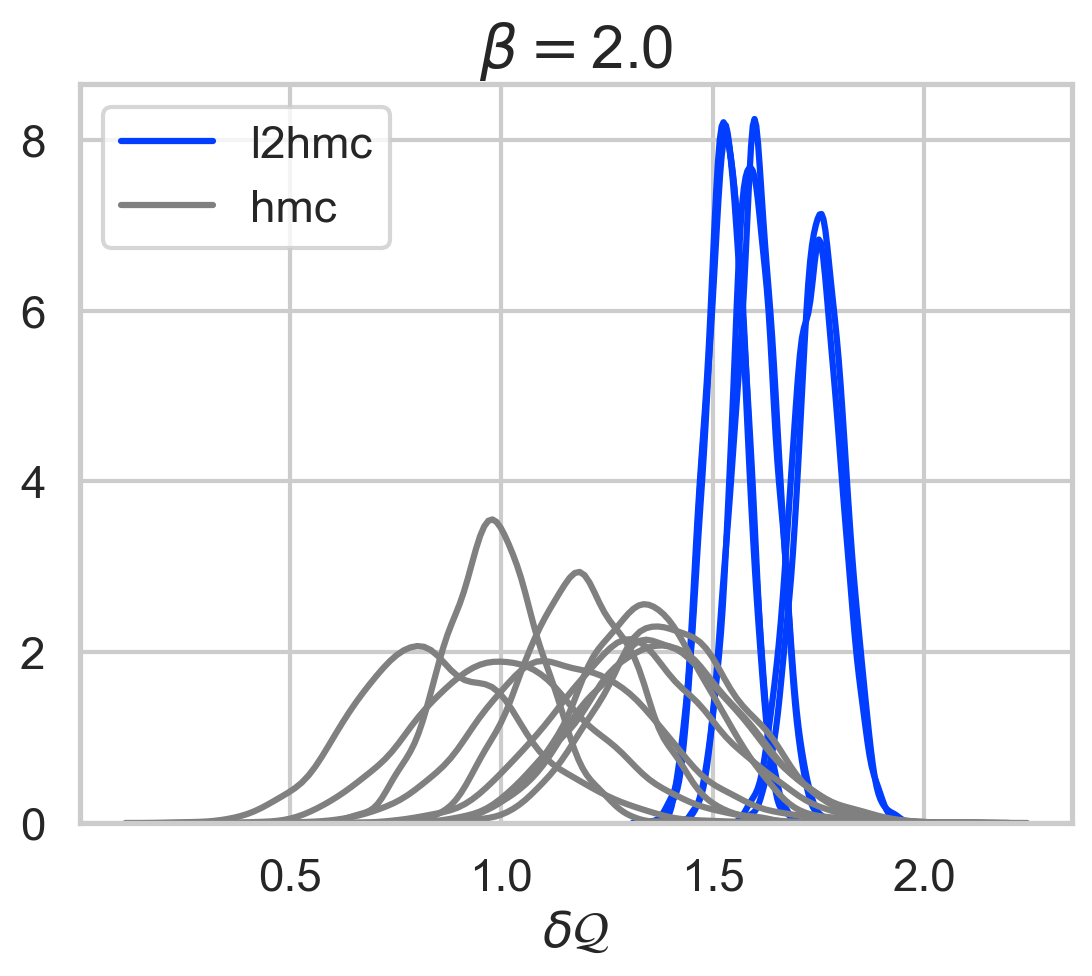

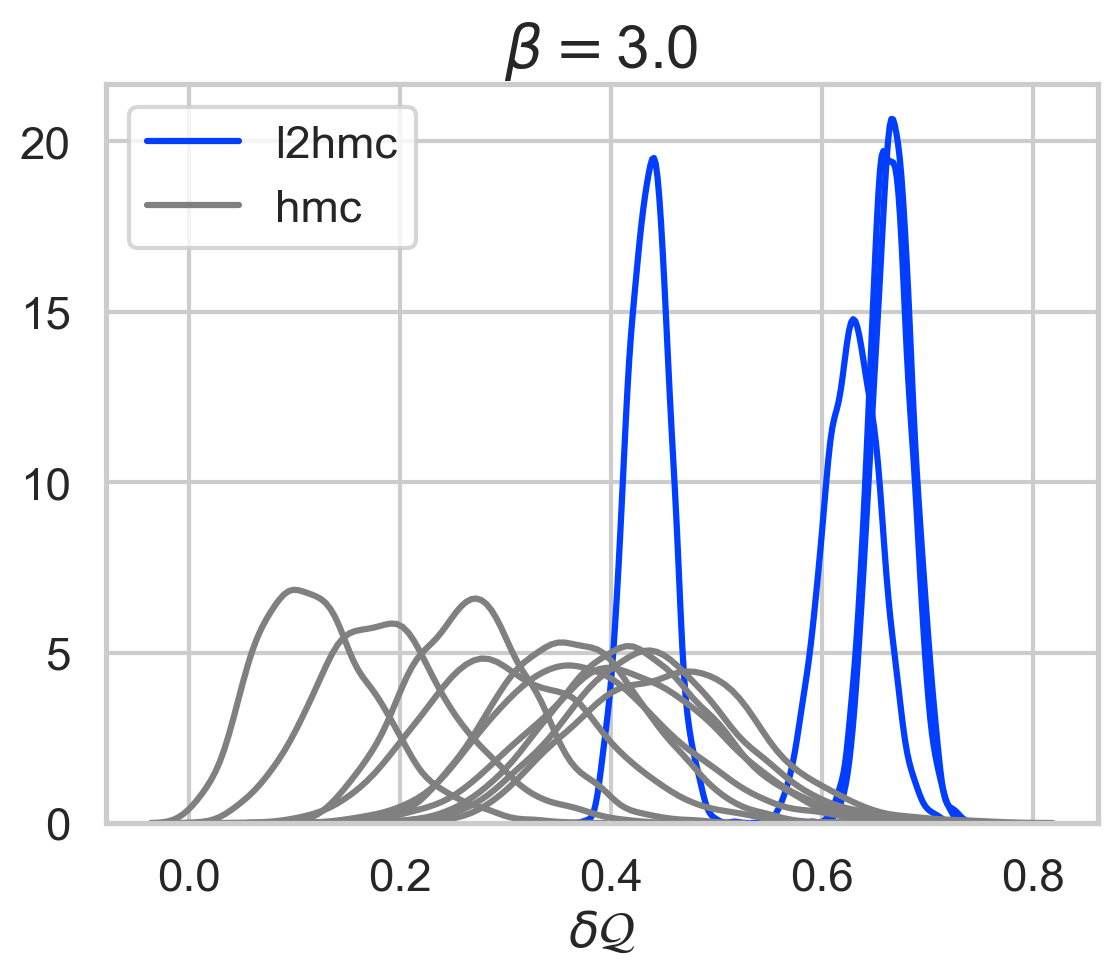

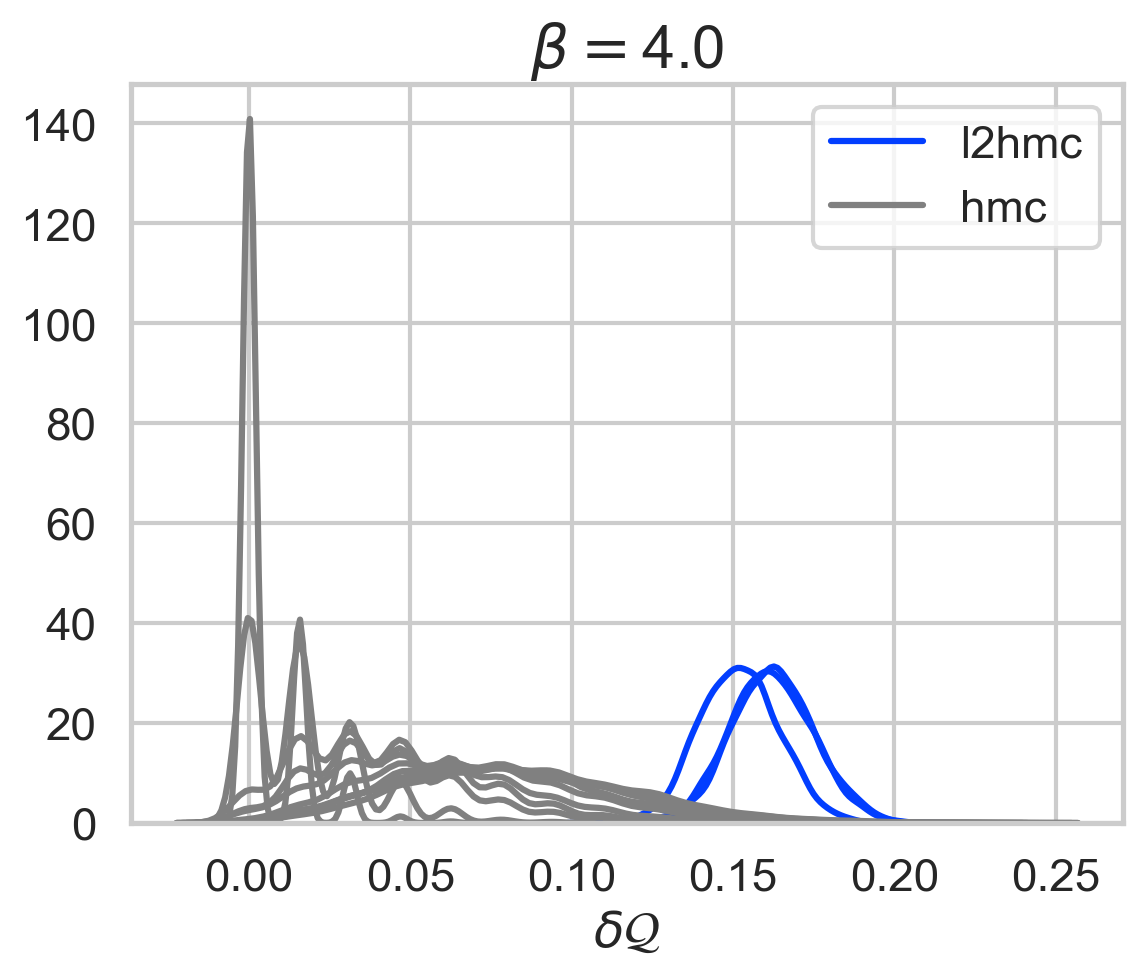

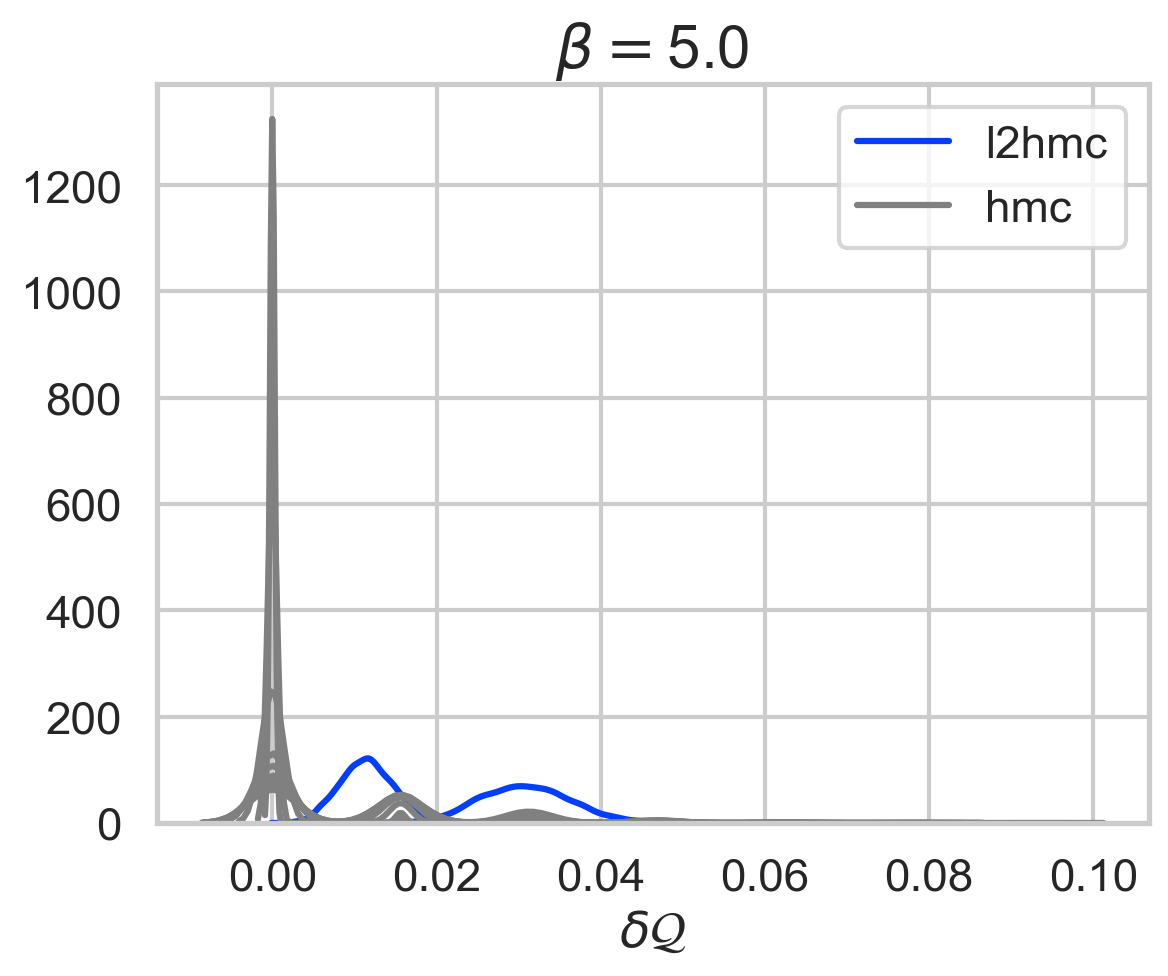

In [133]:
betas_l2hmc = list(dqi_l2hmc.keys())
betas_hmc = list(dqi_hmc.keys())

betas = sorted([x for x in betas_hmc if x in betas_l2hmc])

for beta in betas:
    fig, ax = plt.subplots()
    dqi_l = dqi_l2hmc[beta]
    dqi_h = dqi_hmc[beta]
    data = {}
    data = {'l2hmc': {}, 'hmc': {}}
    kl0 = list(dqi_l.keys())[0]
    for kl, vl in dqi_l.items():
        _, eps = kl
        try:
            data['l2hmc'].update({
                f'{eps:.3g}': vl
            })
        except KeyError:
            data['l2hmc'][f'{eps:.3g}'] = vl
            
        #label_ = 'l2hmc, ' + r"$\varepsilon = $" + f'{eps:.3g}'
        if kl == kl0:
            label = 'l2hmc'
        else:
            label = None
            
        _ = sns.distplot(vl[2500:, :].mean(axis=1), label=label, hist=False, color='C0')
        
    kh0 = list(dqi_h.keys())[0]
    for kh, vh in dqi_h.items():
        _, eps = kh
        try:
            data['hmc'].update({
                f'{eps:.3g}': vh
            })
        except KeyError:
            data['hmc'][f'{eps:.3g}'] = vh
    
        #label_ = 'hmc, ' + r"$\varepsilon = $" + f'{eps:.3g}'
        if kh == kh0:
            label = 'hmc'
        else:
            label = None
            
        _ = sns.distplot(vh[2500:, :].mean(axis=1), label=label, hist=False, color='gray')
        
    _ = ax.legend()
    _ = ax.set_xlabel(r"$\delta \mathcal{Q}$")
    #if beta == 2.0:
    #    _ = ax.set_xlim((0, 2.25))
    #elif beta == 3.0:
    #    _ = ax.set_xlim((0., 1.))
    #elif beta == 4.0:
    #    _ = ax.set_xlim((-0.01, 0.25))
    #elif beta == 5.0:
    #    _ = ax.set_xlim((0, 0.05))
        
    #_ = ax.set_xlim((0, 2.0))
    _ = ax.set_title(r"$\beta = $" + f'{beta}', fontsize='large')

# d3 = {'l2hmc': zl[:, :64], 'hmc': zh}

#fig, ax = plt.subplots()
#for key, val in d3.items():
#    _ = sns.distplot(val.mean(axis=1), label=key, hist=False)
    
_ = ax.legend(loc='best')
#_ = ax.set_xlim((0.5, ax.get_xlim()[1]))
#_ = ax.set_ylim((0, 2))
    

In [145]:
import matplotlib as mpl

In [ ]:
mpl.scale.LogScale(i)

In [84]:
axes.axes_all

## OLDER

<IPython.core.display.Javascript object>


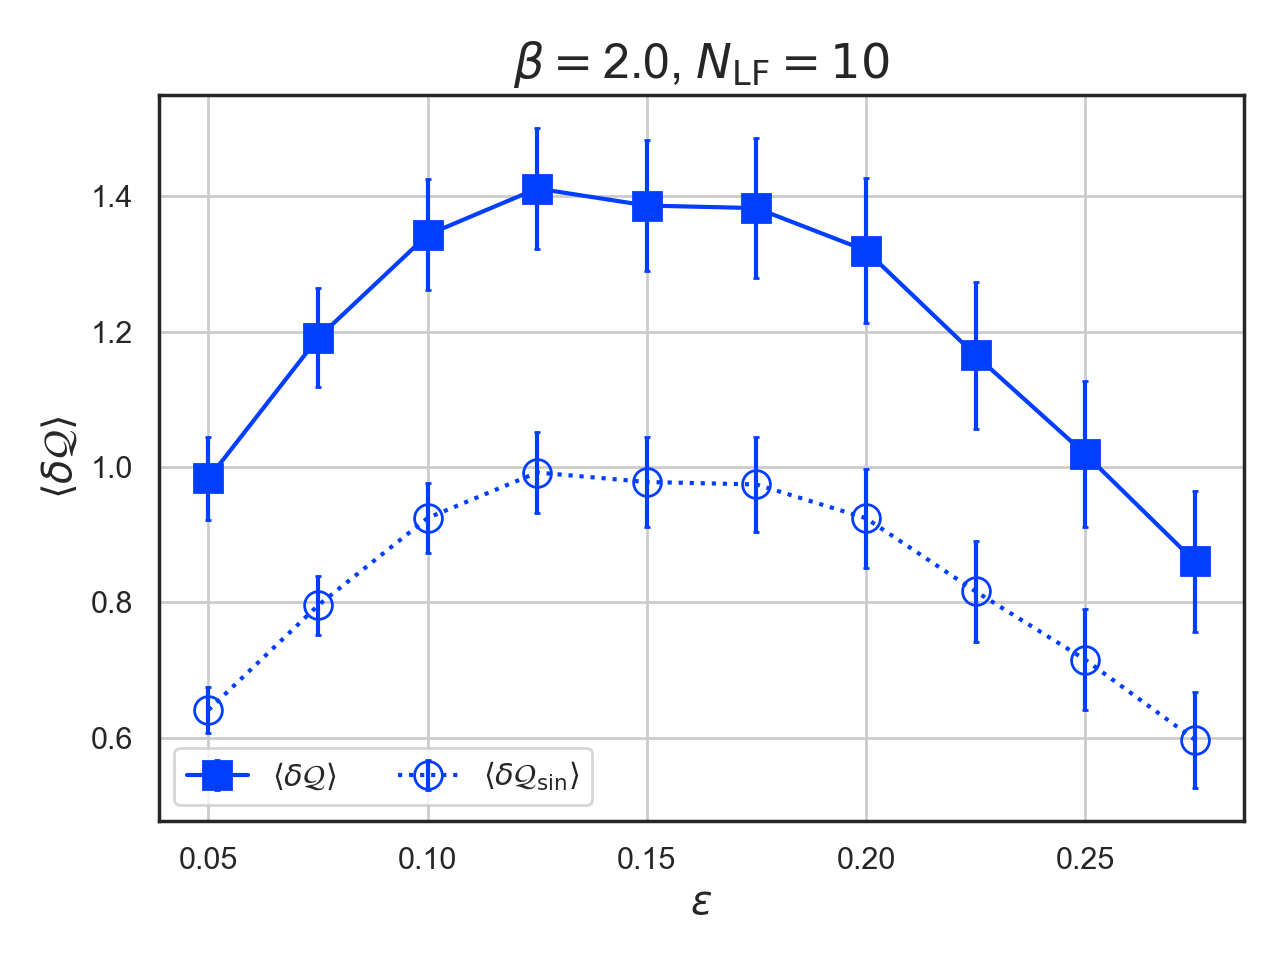

<IPython.core.display.Javascript object>


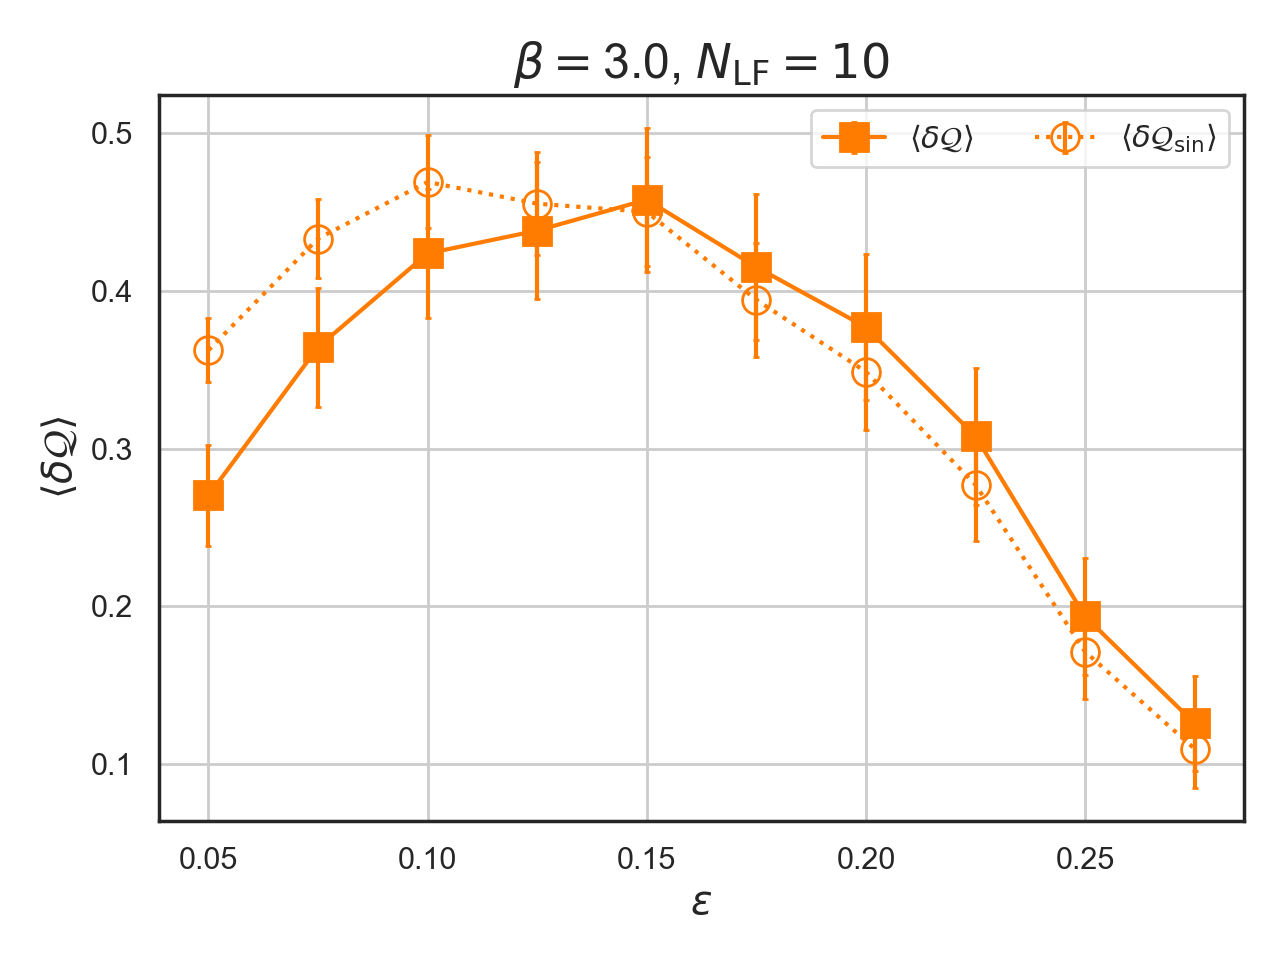

<IPython.core.display.Javascript object>


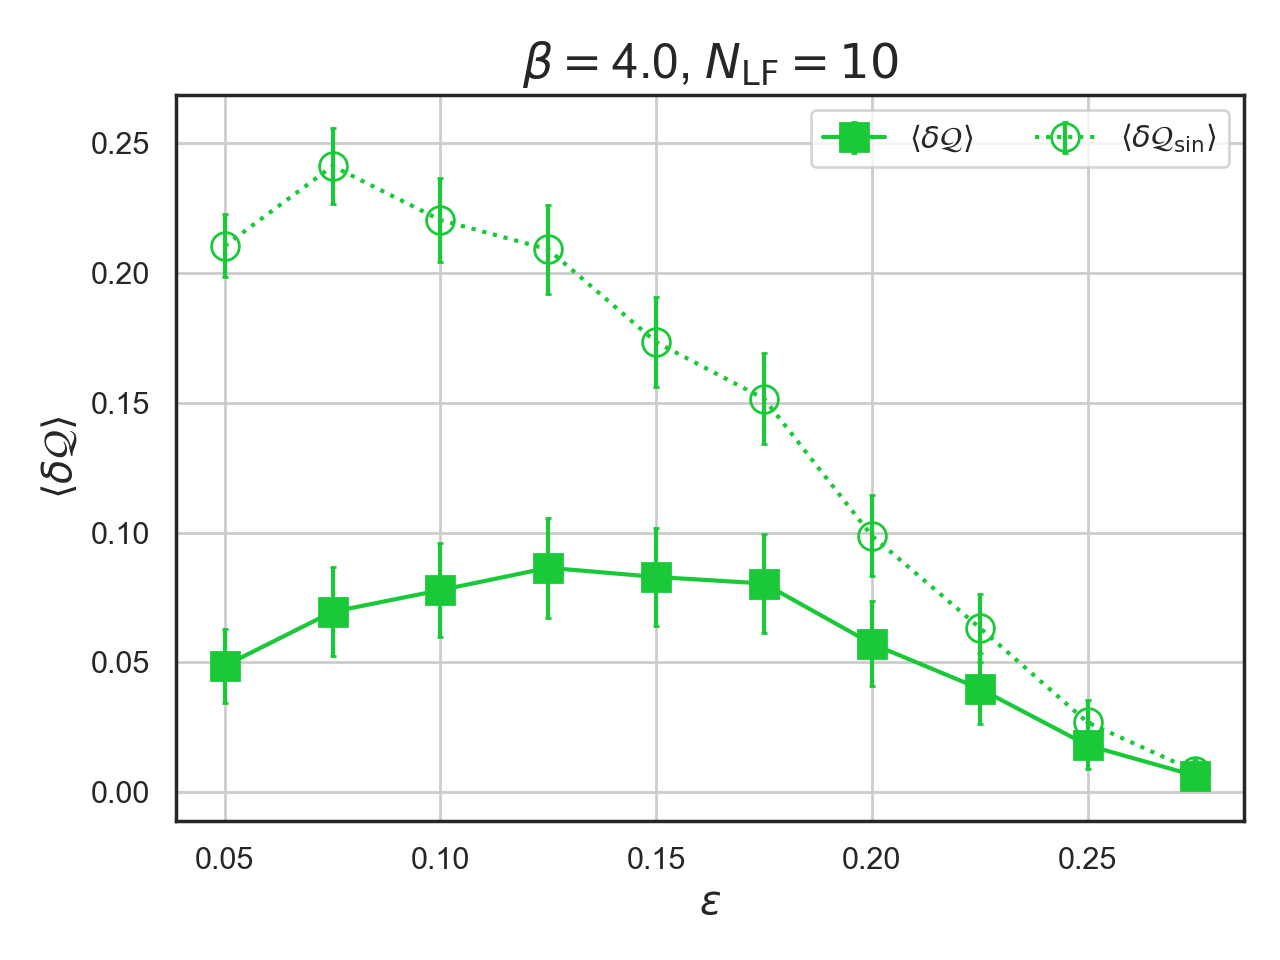

<IPython.core.display.Javascript object>


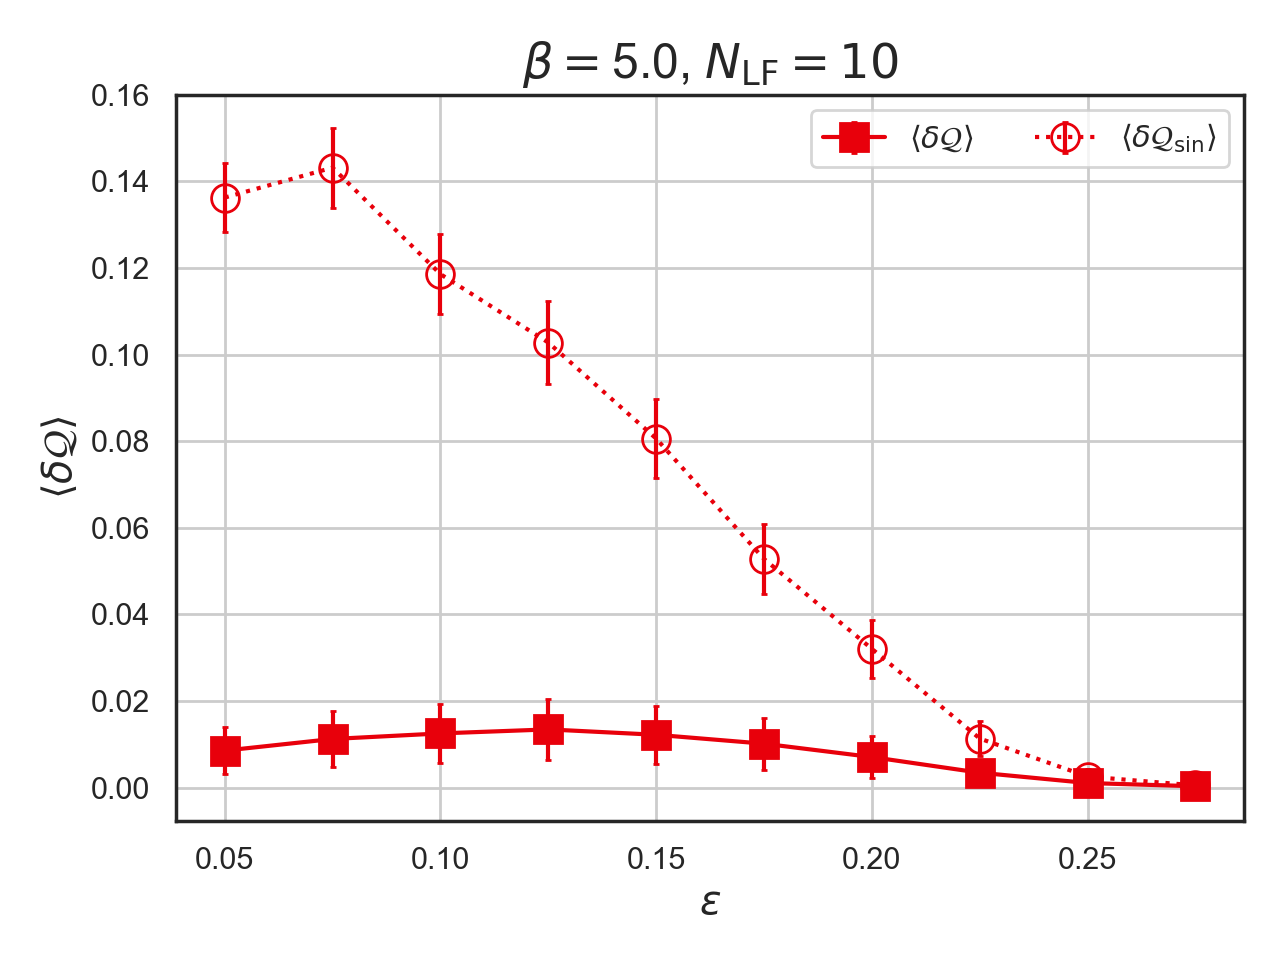

<IPython.core.display.Javascript object>


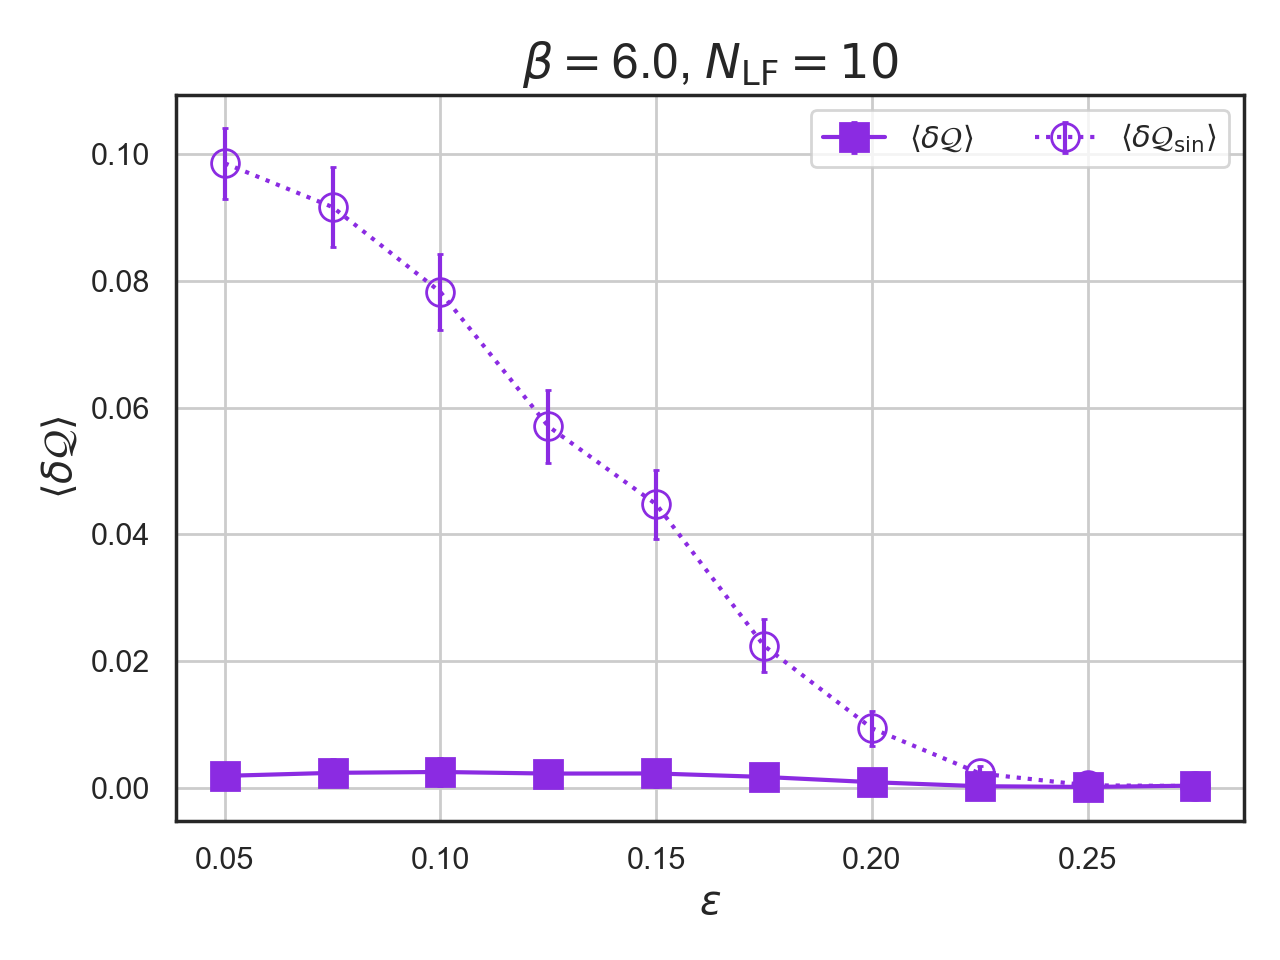

In [16]:
from config import MARKERS, COLORS

#plt.rcParams['savefig.facecolor']='red'
hmc_figs_dir = os.path.join(hmc_log_dir, 'dq_plots_new_2020_10_06')
io.check_else_make_dir(hmc_figs_dir)

dq_int = sorted(dq_int_stats.items(), key=lambda x: x[0])
dq_sin = sorted(dq_sin_stats.items(), key=lambda x: x[0])
#fig, axes = plt.subplots(nrows=len(dq_int_stats.keys()))
#axes = axes.flatten()
for idx, ((kih, vih), (ksh, vsh), k) in enumerate(zip(dq_int, dq_sin)):
    fig, ax = plt.subplots()
    xi = []
    xs = []
    ys = []
    yi = []
    yi_err = []
    ys_err = []
    _vi = sorted(vi.items(), key=lambda x: x[0][1])
    _vs = sorted(vs.items(), key=lambda x: x[0][1])
    #for ki_, vi_ in vi.items():
    for ki_, vi_ in _vi:
        num_steps, eps = ki_
        xi.append(eps)
        yi.append(vi_['avg'])
        yi_err.append(vi_['err'])
        
    for ks_, vs_ in _vs:
        num_steps, eps = ks_
        xs.append(eps)
        ys.append(vs_['avg'])
        ys_err.append(vs_['err'])
        
    _ = ax.errorbar(xi, yi, yi_err, ls='-', marker='s',
                    capsize=1., markersize=10., fillstyle='full',
                    label=r"$\langle\delta\mathcal{Q}\rangle$",
                    color=COLORS[idx])
    _ = ax.errorbar(xs, ys, ys_err, ls=':', marker='o',
                    capsize=1., markersize=10., fillstyle='none',
                    label=r"$\langle\delta\mathcal{Q}_{\sin}\rangle$",
                    color=COLORS[idx])
    
    _ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    _ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
    _ = ax.set_title(r"$\beta = $" + f'{ki}, ' + r"$N_{\mathrm{LF}} = 10$", fontsize='x-large')
    _ = ax.legend(loc='best', ncol=2)
    _ = plt.tight_layout()
    _ = plt.grid(True)
    #_ = ax.set_yscale("log", nonposy='clip')
    timestamp = io.get_timestamp()
    out_file = os.path.join(hmc_figs_dir, f'dq_lf10_stats_beta{ki}_{timestamp}'.replace('.', '') + '.png')
    _ = plt.savefig(out_file, dpi=400, bbox_inches='tight') # , facecolor='#1c1c1c')

<IPython.core.display.Javascript object>


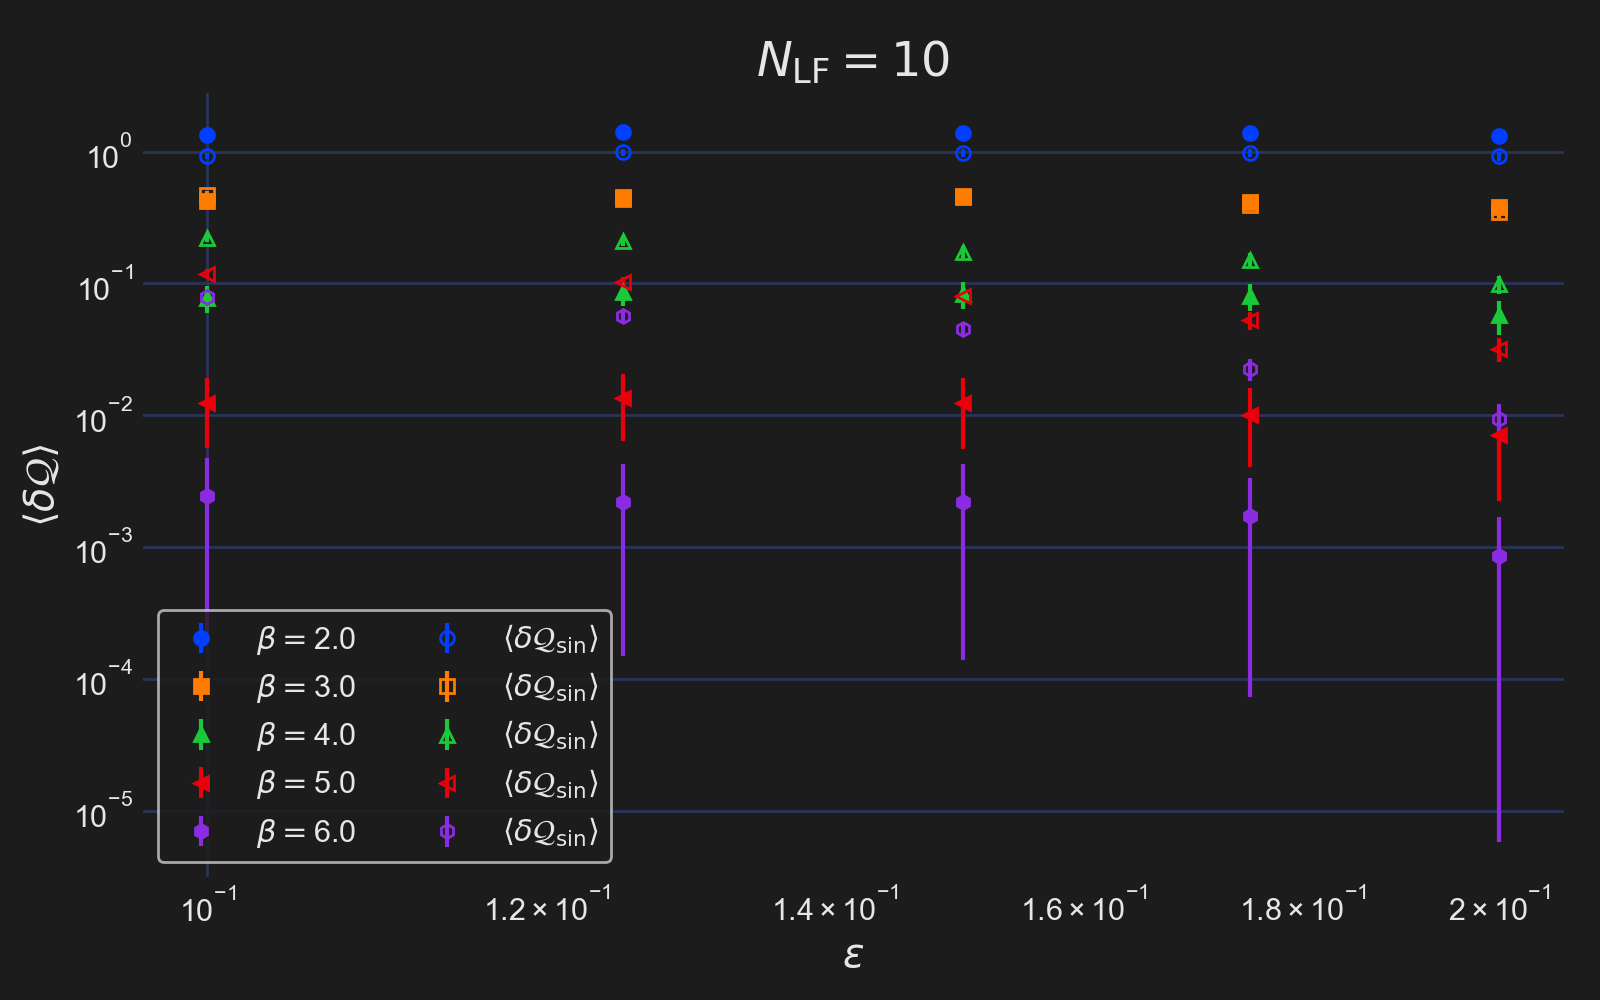

In [48]:
 
    
for idx, (key, val) in enumerate(sorted(dq_int_stats.items())):
fig, ax = plt.subplots(figsize=(8, 5), sharey=True)
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['err'])
        
    _ = ax.errorbar(x, y, y_err, ls='',
                    label=r'$\beta = $' + f'{key}',
                    markersize=5., fillstyle='full',
                    marker=MARKERS[idx], color=COLORS[idx])
    
    
for idx, (key, val) in enumerate(sorted(dq_sin_stats.items())):
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['err'])
        
    _ = ax.errorbar(x, y, y_err, ls='',
                    label=r"$\langle\delta\mathcal{Q}_{\sin}\rangle$",
                    #label=r'$\beta = $' + f'{key}',
                    fillstyle='none', markersize=5.,
                    marker=MARKERS[idx], color=COLORS[idx])
    #_ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    #_ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
    #_ = ax.set_title(r"$N_{\mathrm{LF}} = 10$")
    #_ = axes[1].legend(loc='best')

    #ax.set_title(r"$\beta = $" + f'{key}')
        
_ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
_ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
_ = ax.set_title(r"$N_{\mathrm{LF}} = 10$", fontsize='x-large')
_ = ax.legend(loc='best', ncol=2)
_ = plt.tight_layout()
_ = ax.set_yscale("log", nonposy='clip')
timestamp = io.get_timestamp()
out_file = os.path.join(hmc_figs_dir, f'dq_lf10_stats_{timestamp}.png')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight', facecolor='#1c1c1c')

<IPython.core.display.Javascript object>


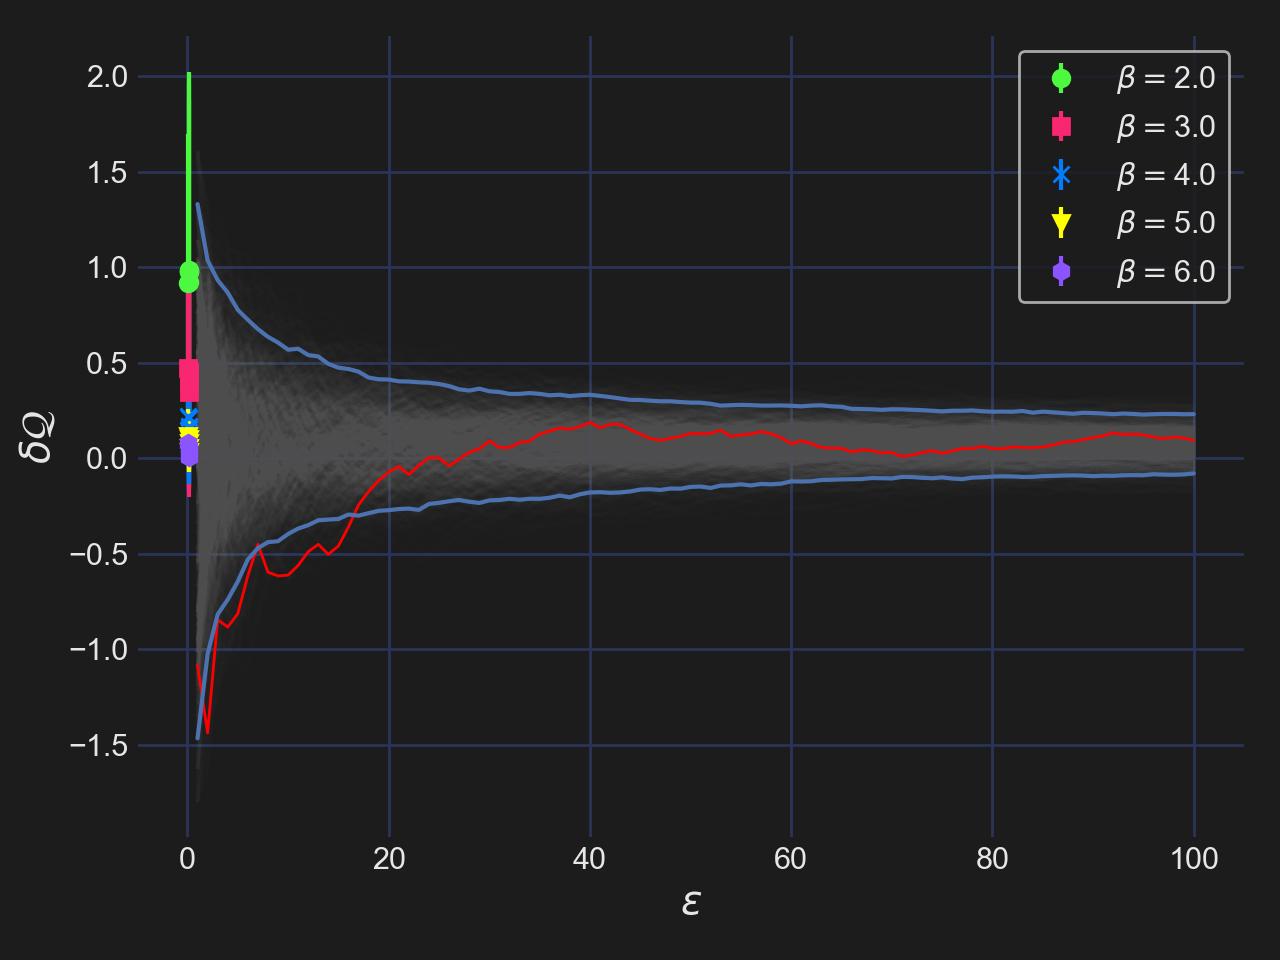

In [146]:
from config import MARKERS

dq_int = {}
#fig, axes = plt.subplots(nrows=len(dq_int_stats.keys()))
#axes = axes.flatten()
fig, ax = plt.subplots()
for idx, (key, val) in enumerate(sorted(dq_sin_stats.items())):
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['std'])
        
    #axes[idx].errorbar(x, y, y_err)
    _ = ax.errorbar(x, y, y_err, ls='', marker=MARKERS[idx], label=r'$\beta = $' + f'{key}')
    _ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    _ = ax.set_ylabel(r"$\delta\mathcal{Q}$", fontsize='large')
    _ = plt.legend(loc='best')
    #ax.set_title(r"$\beta = $" + f'{key}')
    _ = plt.tight_layout()
        

In [94]:
io.print_dict(dq_int_stats, name='dq_int_stats')
io.print_dict(dq_sin_stats, name='dq_sin_stats')

dq_int_stats:
------------
  4.0:
  ---
    (10, 0.175):
    -----------
      avg: 0.07933614403009415
      std: 0.28694701194763184
      min: 0
      max: 3
    (10, 0.125):
    -----------
      avg: 0.08561745285987854
      std: 0.29094022512435913
      min: 0
      max: 3
    (10, 0.1):
    ---------
      avg: 0.07720345258712769
      std: 0.27463144063949585
      min: 0
      max: 3
    (10, 0.2):
    ---------
      avg: 0.05437120795249939
      std: 0.24383173882961273
      min: 0
      max: 3
    (10, 0.16):
    ----------
      avg: 0.07912912219762802
      std: 0.28512659668922424
      min: 0
      max: 4
    (10, 0.15):
    ----------
      avg: 0.0805392935872078
      std: 0.28575170040130615
      min: 0
      max: 3
  3.0:
  ---
    (10, 0.15):
    ----------
      avg: 0.4561446011066437
      std: 0.6807785034179688
      min: 0
      max: 6
    (10, 0.2):
    ---------
      avg: 0.3745351731777191
      std: 0.6879435777664185
      min: 0
      max: 7
  

In [80]:
%debug

> /Users/saforem2/l2hmc-qcd/l2hmc-qcd/utils/file_io.py(128)print_dict()
    126         sep_str = indent_str + len(name) * '-'
    127         log(sep_str, **kwargs)
--> 128     for key, val in d.items():
    129         if isinstance(d, (AttrDict, dict)):
    130             print_dict(val, indent=indent+2, name=str(key), **kwargs)

ipdb> x = d
ipdb> x.items()
*** AttributeError: 'tuple' object has no attribute 'items'
ipdb> x
(0.079336144, 0.286947)
ipdb> x
(0.079336144, 0.286947)
ipdb> quit


In [77]:
dq_sin_stats

{4.0: {(10, 0.175): (0.1521019, 0.26443395),
  (10, 0.125): (0.20872988, 0.2563737),
  (10, 0.1): (0.220758, 0.24189393),
  (10, 0.2): (0.09623339, 0.23055416),
  (10, 0.16): (0.15968636, 0.26125705),
  (10, 0.15): (0.170749, 0.25906423)},
 3.0: {(10, 0.15): (0.4495216, 0.5215852),
  (10, 0.2): (0.34716162, 0.54797816),
  (10, 0.175): (0.38995403, 0.539692),
  (10, 0.1): (0.47058344, 0.43851098),
  (10, 0.125): (0.4528759, 0.48418865)},
 5.0: {(10, 0.1): (0.11855335, 0.13835438),
  (10, 0.175): (0.05252867, 0.12167294),
  (10, 0.2): (0.032098874, 0.101736665),
  (10, 0.125): (0.10199289, 0.14115505),
  (10, 0.15): (0.08075489, 0.13741735)},
 6.0: {(10, 0.15): (0.04474526, 0.08106277),
  (10, 0.125): (0.057241946, 0.08608513),
  (10, 0.175): (0.022115912, 0.063013814),
  (10, 0.1): (0.07813317, 0.09022369),
  (10, 0.2): (0.008726718, 0.041257907)},
 2.0: {(10, 0.15): (0.9800828, 0.97632915),
  (10, 0.175): (0.9737217, 1.0451647),
  (10, 0.125): (0.986235, 0.88797414),
  (10, 0.1): (0.91

In [66]:
from utils.data_utils import therm_arr

dq_int = {}
for key, val in dq_int_dict.items():
    beta = key
    for k, v in val.items():
        data = therm_arr(v, ret_steps=False)
        try:
            dq_int[key].update({
                k: (np.mean(data), np.std(data))
            })
        except KeyError:
            dq_int[key] = {
                k: (np.mean(data), np.std(data))
            }
    

{4.0: {(10, 0.175): (0.079336144, 0.286947),
  (10, 0.125): (0.08561745, 0.29094023),
  (10, 0.1): (0.07720345, 0.27463144),
  (10, 0.2): (0.054371208, 0.24383174),
  (10, 0.16): (0.07912912, 0.2851266),
  (10, 0.15): (0.08053929, 0.2857517)},
 3.0: {(10, 0.15): (0.4561446, 0.6807785),
  (10, 0.2): (0.37453517, 0.6879436),
  (10, 0.175): (0.4106016, 0.6855541),
  (10, 0.1): (0.4241798, 0.61346316),
  (10, 0.125): (0.43722662, 0.6457952)},
 5.0: {(10, 0.1): (0.011617525, 0.10748271),
  (10, 0.175): (0.008898574, 0.095519304),
  (10, 0.2): (0.0063360166, 0.08042181),
  (10, 0.125): (0.012418249, 0.11172512),
  (10, 0.15): (0.011597873, 0.10837155)},
 6.0: {(10, 0.15): (0.0014181541, 0.038042184),
  (10, 0.125): (0.0018049281, 0.042718466),
  (10, 0.175): (0.00091415126, 0.030859185),
  (10, 0.1): (0.0018011117, 0.042489406),
  (10, 0.2): (0.00043362874, 0.021005195)},
 2.0: {(10, 0.15): (1.3870312, 1.4414281),
  (10, 0.175): (1.3827344, 1.5342593),
  (10, 0.125): (1.3982812, 1.3342794),


In [60]:
k = list(dq_int_dict[2.0].keys())[0]

In [61]:
k

(10, 0.15)

In [63]:
dq_int_dict[2.][k].shape

(5000, 64)

In [44]:
dq_int_dict.keys()

dict_keys([4.0])

In [15]:
hdir = hmc_dirs[0]
run_data_files = sorted(hdir.glob('**/*.z'))

In [17]:
hdirs = [x for x in hdir.iterdir() if x.is_dir()]
hdirs

[PosixPath('/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi2_bf2-2020-10-05-171043/beta2-2020-10-05-1710')]

In [19]:
zfiles = sorted(hdirs[0].glob('**/*.z'))
zfiles

[]

In [2]:
base_dir = os.path.abspath('/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/')
hmc_dirs = [
    os.path.join(base_dir, i) for i in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, i))
]

def get_run_data(hmc_dir, fname):
    tmp_dir = os.listdir(hmc_dir)[0]
    run_dir = os.path.join(hmc_dir, tmp_dir) 
    run_data_dir = os.path.j

['/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi2_bf2-2020-10-05-171043',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps0175_bi4_bf4-2020-10-05-131208',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps015_bi3_bf3-2020-10-05-125013',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps02_bi3_bf3-2020-10-05-125734',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi5_bf5-2020-10-05-131908',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_bi3_bf3-2020-10-05-120411',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_bi4_bf4-2020-10-05-121415',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps015_bi6_